In [2]:
RAMDOM_STATE = 916113568

import json
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sn

import time
import re
import os
import math
import pickle

from collections import defaultdict

from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import classification_report, top_k_accuracy_score
from tqdm import tqdm
import unicodedata



import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer,word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Load Data

In [ ]:
# load data
#pickle.dump(data, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data.p', 'wb'))
class_labels = ["ai","arch","dm","edu","inter","net","par","secu","ssy","theo","vr"]
data = pickle.load( open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data.p', 'rb'))
data

,webname,filename,publish,title,abstract,Class,Categories
0,S107158192030164,0,sd,Talking datasets – Understanding data sensemak...,The sharing and reuse of data are seen as crit...,inter,[inter]
1,S107158192030163,1,sd,Evaluation of haptic virtual reality user inte...,Three-dimensional (3D) visualization has been ...,inter,[inter]
2,S107158192030184,2,sd,Shocking advantage! Improving digital game per...,As digital gaming has grown from a leisure act...,inter,[inter]
3,S107158192100078,3,sd,An empirical investigation of domestic energy ...,Which device in your home uses the most electr...,inter,[inter]
4,S107158192100094,4,sd,EyeTAP: Introducing a multimodal gaze-based te...,One of the main challenges of gaze-based inter...,inter,[inter]
...,...,...,...,...,...,...,...
3274,S108480452100082,3274,sd,Service migration in multi-access edge computi...,With the development of the internet of things...,net,[net]
3275,S108480452030391,3275,sd,Mutual authentication with multi-factor in IoT...,Authentication of restricted memory devices pr...,net,[net]
3276,S108480452100002,3276,sd,MedHypChain: A patient-centered interoperabili...,"Recently, an infectious disease, coronavirus d...",net,[net]
3277,S108480452100045,3277,sd,Temporary immutability: A removable blockchain...,"Recently, blockchain adoption in prosumer-side...",net,[net]


In [ ]:
# Load stopwords
stop_words = set(stopwords.words("english"))
stop_words2 = []
for i in stop_words:
  word = i[0].upper()+i[1:].lower()
  stop_words2.extend([i,word,i.upper()])

In [ ]:
# Load Common Words
f = open("/content/drive/Shareddrives/My Dessertation/py/common.txt")
lines = re.sub(' +', ' ', re.sub('\n',' ', f.read())) 
f.close()
tokenizer = RegexpTokenizer(r'\w+')
common = tokenizer.tokenize(lines)
for k in tokenizer.tokenize(lines):
  common.extend([k[0].upper()+k[1:],k.upper()])

# Data Preprocessing



## Function

In [ ]:
def LoadTxt(address, df):
  for files in os.listdir(address):
    #print(files)
    f = open(address+'/'+files)
    lines = f.read()
    f.close()
    lines = re.sub(' +', ' ', re.sub('\n',' ', lines))
    if 'abstract' in lines[:10].lower():
      lines = lines[9:]
    df.content.iloc[int(files[:-4])] = lines
  return df

In [ ]:
def RemoveControlCharacters(s):
  return "".join(ch for ch in s if unicodedata.category(ch)[0]!="C")

In [ ]:
def RemoveAuthor(string): # 1126 1514 2208 2332 3183
  a = re.sub('\(([^()]{0,70}(et[ ,;&]{1,10}al)[^()]{0,70}){1,70}\)', ' ', string) # Name follow with et al.,   '\(([^()]*(et[ ,;&]+al)[^()]*)+\)'
  b = re.sub('\(([^()\d]{0,70}((19\d{2})|(20[0-2]\d))[^()\d]{0,70}){1,70}\)', ' ', a) # () with year 19xx - 2022  '\(([^()\d]*((19\d{2})|(20[0-2]\d))[^()\d]*)+\)'
  c = re.sub('\[([^[\]\d]{0,70}((19\d{2})|(20[0-2]\d))[^[\]\d]{0,70}){1,70}\]', ' ', b) # [] with year 19xx - 2022   [Akhter and Black 2015]
  d = re.sub('([A-Z][a-z]+? et[ ,;&]{1,10}al.)', ' ', c)
  return d

In [ ]:
def RemoveSpecialSymbol(string):
  a = re.sub('\(\d+\)',' ',string)  # delete bracket and numbers eg. (1), (100) etc.
  b = re.sub('\[\d+(\W\s?\d+)*\]',' ',a) # delete citation and numbers eg. [1], [2,24] etc.
  c = re.sub('fig(ure)?(s)?\.?\ ?\d+',' ',b) # delete figure and numbers eg. figure 1, fig 2., fig.3 etc. 
  d = re.sub('\d+(?!G|D)','',c) # delete numbers except 2G, 3G, 4G, 3D etc.
  e = re.sub('[*!"$&+--−_,:;=?@#|\'<>()\[\]]',' ',d) # delete special symbol eg.!@#$%^&*()_-+=<>{}[]\|?;: etc.
  f = re.sub(r'_+\w*',' ',e) # delete multiply _
  g = re.sub(r'(\w)\1\1\w*', ' ',f) # delete 删除从开头开始算，重复3次以上字母的词
  #h = re.sub('(\w+)?arxiv(\w+)?',' ',g)
  i = re.sub('  +',' ',g)
  return i

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def checkFirstCap(word):
  if word[0].isupper() and word[1:].islower():
    word = word.lower()
  return word

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
#wn_dict = set(wordnet.words())
def preprocess9(sentence):
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(sentence) # Tokenizer words
  tokens2 = [checkFirstCap(w) for w in tokens] # Covert the first character to lower is capital  eg. Word -> word
  # Lemmatizer words, only keep words in Noun
  lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens2]  

  # Filter words not stopwords & common words
  # Filter words and only keep words with length greater than 2 or length with 2 but words are capital eg. VR, lab etc
  filtered_words = [w for w in lemma_words if len(w) > 2 or (len(w) == 2 and w.isupper()) if not w in stop_words2 and not w in common] 
  return filtered_words

In [ ]:
def checkToken(token, sets):
  if token in sets:
    return token
  else:
    if token.lower() in sets:
      return token.lower()
    elif token.upper() in sets:
      return token.upper()
    else:
      return ''

In [ ]:
original_corpus = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/original_corpus.p','rb'))
final_corpus = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/final_corpus.p','rb'))


In [ ]:
final_corpus = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/final_corpus.p','rb'))
global corpus2_sets
corpus2_sets = set(final_corpus.keys())
def postcleaning(tokenlist):
  chkToken = [checkToken(w,corpus2_sets) for w in tokenlist]
  filter_word = [w for w in chkToken if len(w) > 1]
  return filter_word

## preprocess

In [ ]:
data["content"]=""
address = '/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/original/'
LoadTxt(address, data)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,webname,filename,publish,title,abstract,Class,Categories,content
0,S107158192030164,0,sd,Talking datasets – Understanding data sensemak...,The sharing and reuse of data are seen as crit...,inter,[inter],The sharing and reuse of data are seen as crit...
1,S107158192030163,1,sd,Evaluation of haptic virtual reality user inte...,Three-dimensional (3D) visualization has been ...,inter,[inter],Three-dimensional (3D) visualization has been ...
2,S107158192030184,2,sd,Shocking advantage! Improving digital game per...,As digital gaming has grown from a leisure act...,inter,[inter],As digital gaming has grown from a leisure act...
3,S107158192100078,3,sd,An empirical investigation of domestic energy ...,Which device in your home uses the most electr...,inter,[inter],Which device in your home uses the most electr...
4,S107158192100094,4,sd,EyeTAP: Introducing a multimodal gaze-based te...,One of the main challenges of gaze-based inter...,inter,[inter],One of the main challenges of gaze-based inter...
...,...,...,...,...,...,...,...,...
3274,S108480452100082,3274,sd,Service migration in multi-access edge computi...,With the development of the internet of things...,net,[net],With the development of the internet of things...
3275,S108480452030391,3275,sd,Mutual authentication with multi-factor in IoT...,Authentication of restricted memory devices pr...,net,[net],Authentication of restricted memory devices pr...
3276,S108480452100002,3276,sd,MedHypChain: A patient-centered interoperabili...,"Recently, an infectious disease, coronavirus d...",net,[net],"Recently, an infectious disease, coronavirus d..."
3277,S108480452100045,3277,sd,Temporary immutability: A removable blockchain...,"Recently, blockchain adoption in prosumer-side...",net,[net],"Recently, blockchain adoption in prosumer-side..."


In [ ]:
for i in tqdm(range(len(data))):
  data.content.iloc[i] = RemoveControlCharacters(data.content.iloc[i])

  0%|          | 0/3279 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 3279/3279 [01:05<00:00, 49.80it/s]


In [ ]:
# This Step need to manully pause (not stop) if stuck
# 1125, 1513, 2207, 2331 need to Remove Author manully
for i in tqdm(range(len(data))):
  try:
    data.content.iloc[i] = RemoveAuthor(data.content.iloc[i])
  except:
    print(i)

  0%|          | 0/3279 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
 36%|███▌      | 1170/3279 [00:29<01:25, 24.75it/s]

1125


 48%|████▊     | 1564/3279 [00:35<00:54, 31.35it/s]

1513


 68%|██████▊   | 2243/3279 [00:46<00:29, 34.58it/s]

2207


 72%|███████▏  | 2363/3279 [01:09<02:29,  6.14it/s]

2331


100%|██████████| 3279/3279 [01:32<00:00, 35.50it/s]


In [ ]:
c = re.sub('\[([^[\]\d]{0,10}((19\d{2})|(20[0-2]\d))[^[\]\d]{0,70}){1,70}\]', ' ', data.content.iloc[1125]) # remove [] with year 19xx - 2022   eg. [2009]
d = re.sub('([A-Z][a-z]+? et[ ,;&]{1,10}al.)', ' ', c) # remove name follow with el at. eg. Hassin et al.
data.content.iloc[1125] = d

In [ ]:
a = re.sub('\(([^()]{0,35}(et[ ,;&]{1,10}al)[^()]{0,70}){1,70}\)', ' ', data.content.iloc[1513]) # remove () with Name follow with et al.,   eg. (Lewis et al., 2005)
b = re.sub('\(([^()\d]{0,70}((19\d{2})|(20[0-2]\d))[^()\d]{0,70}){1,70}\)', ' ', a) # remove () with year 19xx - 2022  eg. (Erl, 2008), (2005)
d = re.sub('([A-Z][a-z]+? et[ ,;&]{1,10}al.)', ' ', b)  # remove name follow with et al.  eg. Adjoyan et al.
data.content.iloc[1513] = d

In [ ]:
b = re.sub('\(([^()\d]{0,70}((19\d{2})|(20[0-2]\d))[^()\d]{0,5}){1,70}\)', ' ', data.content.iloc[2207]) # remove () with year 19xx - 2022  eg.(Yang et al. 2018)
d = re.sub('([A-Z][a-z]+? et[ ,;&]{1,10}al.)', ' ', b) # remove name with et al. eg. Yue et al.
data.content.iloc[2207] = d

In [ ]:
a = re.sub('\(([^()]{0,70}(et[ ,;&]{1,10}al)[^()]{0,70}){1,70}\)', ' ', data.content.iloc[2331]) # remove () with Name follow with et al.,   eg. (Kleiner et al., 2014)
b = re.sub('\(([^()\d]{0,17}((19\d{2})|(20[0-2]\d))[^()\d]{0,70}){1,70}\)', ' ', a) # () with year 19xx - 2022  'eg. (Kato, 1995), (2010)
d = re.sub('([A-Z][a-z]+? et[ ,;&]{1,10}al.)', ' ', c) # remove name follow with et al. eg. Mardia et al.
data.content.iloc[2331] = d

In [ ]:
for i in tqdm(range(len(data))):
  data.content.iloc[i] = RemoveSpecialSymbol(data.content.iloc[i])

In [ ]:
data['token'] = ''
for i in tqdm(range(len(data))):
  data.token.iloc[i] = preprocess9(data.content.iloc[i])

  0%|          | 0/3279 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 3279/3279 [1:16:54<00:00,  1.41s/it]


In [ ]:
#data1 = data.copy()
#pickle.dump(data1, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data1.p', 'wb'))
data1 = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data1.p', 'rb'))

In [ ]:
data1

,webname,filename,publish,title,abstract,Class,Categories,content,token
0,S107158192030164,0,sd,Talking datasets – Understanding data sensemak...,The sharing and reuse of data are seen as crit...,inter,[inter],The sharing and reuse of data are seen as crit...,"[reuse, data, critical, complex, despite, pote..."
1,S107158192030163,1,sd,Evaluation of haptic virtual reality user inte...,Three-dimensional (3D) visualization has been ...,inter,[inter],Three dimensional 3D visualization has been wi...,"[dimensional, 3D, visualization, widely, compu..."
2,S107158192030184,2,sd,Shocking advantage! Improving digital game per...,As digital gaming has grown from a leisure act...,inter,[inter],As digital gaming has grown from a leisure act...,"[digital, grown, leisure, activity, competitiv..."
3,S107158192100078,3,sd,An empirical investigation of domestic energy ...,Which device in your home uses the most electr...,inter,[inter],Which device in your home uses the most electr...,"[device, electricity, understand, domestic, co..."
4,S107158192100094,4,sd,EyeTAP: Introducing a multimodal gaze-based te...,One of the main challenges of gaze-based inter...,inter,[inter],One of the main challenges of gaze based inter...,"[challenge, gaze, interaction, ability, distin..."
...,...,...,...,...,...,...,...,...,...
3274,S108480452100082,3274,sd,Service migration in multi-access edge computi...,With the development of the internet of things...,net,[net],With the development of the internet of things...,"[development, internet, IoT, concept, network,..."
3275,S108480452030391,3275,sd,Mutual authentication with multi-factor in IoT...,Authentication of restricted memory devices pr...,net,[net],Authentication of restricted memory devices pr...,"[authentication, restrict, memory, device, sig..."
3276,S108480452100002,3276,sd,MedHypChain: A patient-centered interoperabili...,"Recently, an infectious disease, coronavirus d...",net,[net],Recently an infectious disease coronavirus dis...,"[recently, infectious, disease, coronavirus, d..."
3277,S108480452100045,3277,sd,Temporary immutability: A removable blockchain...,"Recently, blockchain adoption in prosumer-side...",net,[net],Recently blockchain adoption in prosumer side ...,"[recently, blockchain, adoption, prosumer, tra..."


## Create Own Dictionary

In [ ]:
list(original_corpus.values())

In [ ]:
sorted_original_corpus

[(1, 76027),
 (2, 20922),
 (3, 10062),
 (4, 6409),
 (5, 4337),
 (6, 3444),
 (7, 2539),
 (8, 2104),
 (9, 1710),
 (10, 1505),
 (11, 1324),
 (12, 1117),
 (13, 946),
 (14, 848),
 (15, 803),
 (16, 747),
 (17, 680),
 (18, 625),
 (19, 577),
 (20, 530),
 (21, 486),
 (22, 443),
 (23, 391),
 (24, 388),
 (25, 347),
 (26, 350),
 (27, 336),
 (28, 306),
 (29, 273),
 (30, 311),
 (31, 249),
 (32, 247),
 (33, 257),
 (34, 238),
 (35, 202),
 (36, 218),
 (37, 194),
 (38, 183),
 (39, 173),
 (40, 193),
 (41, 146),
 (42, 158),
 (43, 134),
 (44, 166),
 (45, 146),
 (46, 149),
 (47, 154),
 (48, 156),
 (49, 162),
 (50, 127),
 (51, 133),
 (52, 115),
 (53, 117),
 (54, 110),
 (55, 118),
 (56, 110),
 (57, 126),
 (58, 93),
 (59, 110),
 (60, 93),
 (61, 93),
 (62, 104),
 (63, 84),
 (64, 98),
 (65, 85),
 (66, 81),
 (67, 82),
 (68, 74),
 (69, 82),
 (70, 101),
 (71, 74),
 (72, 58),
 (73, 76),
 (74, 77),
 (75, 76),
 (76, 76),
 (77, 82),
 (78, 68),
 (79, 68),
 (80, 75),
 (81, 58),
 (82, 61),
 (83, 55),
 (84, 51),
 (85, 46),

In [ ]:
from collections import Counter
sorted_original_corpus = sorted(Counter(original_corpus.values()).items())
x = []
y = []
for i in sorted_original_corpus:
  x.append(i[0])
  y.append(np.log(i[1]))

In [ ]:
from collections import Counter
# create original dictionary
original_corpus = Counter()
for i in range(len(data1)):
  original_corpus += Counter(data1.token.iloc[i])

In [ ]:
corpus_set = set(original_corpus.keys())
print(len(corpus_set))
original_corpus.items()

In [ ]:
# Check words uppercase & lowercase 
# keep the lowercase if both cases exist
for k in corpus_set:
  if k == k.upper():
    if k.lower() in corpus_set:
      original_corpus[k.lower()] += original_corpus[k]
      del original_corpus[k]
  elif k == k.lower():
    continue
  else:
    if k.lower() in corpus_set:
      original_corpus[k.lower()] += original_corpus[k]
      del original_corpus[k]
      
print(len(original_corpus.items()))
original_corpus.items()

In [ ]:
for k, v in original_corpus.items():
  if len(k) > 20:
    print(k,v)

In [ ]:
# Filter words with length less than 20 and frequency greater than 10 as final dictionary
final_corpus = original_corpus.copy()
corpus_set2 = set(final_corpus.keys())
for k in corpus_set2:
  if len(k) < 20 and final_corpus[k] > 10:
    continue
  else:
    del final_corpus[k]

## Post Data Cleaning

In [5]:
#pickle.dump(original_corpus, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/original_corpus.p','wb'))
#pickle.dump(final_corpus, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/final_corpus.p','wb'))
original_corpus = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/original_corpus.p','rb'))
print("Original amounts of term is",len(original_corpus))
final_corpus = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/final_corpus.p','rb'))
print("Final amounts of term after data clearning is",len(final_corpus))

Original amounts of term is 156235
Final amounts of term after data clearning is 27159


In [ ]:
data_common = data1.copy()
data_common['token'] = data_common['token'].map(lambda s:postcleaning(s)) 
pickle.dump(data_common, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data_common.p','wb'))
data_common.to_csv('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data_common.tsv', sep=',')

# Build Model

In [ ]:
data_common = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/data_common.p','rb'))

In [ ]:
data_common.Class.value_counts()

dm       378
theo     371
arch     334
ssy      333
par      307
edu      305
net      264
vr       255
ai       246
inter    245
secu     241
Name: Class, dtype: int64

In [ ]:
for k, v in final_corpus.items():
  if v > 20000:
    print(k)

## Function

In [ ]:
def TopKcheckCat(K, labels, PredLabel, TrueLabel, returncat = False):
  sortprob = np.argsort(PredLabel)[::-1]  # Sorted by order
  for prob in range(K):                   # check first k
    if labels[sortprob[prob]] == TrueLabel :#and  PredLabel[sortprob[0]]*0.5 <= PredLabel[sortprob[prob]]:
      return True if not returncat else sortprob[prob]
  return -1
def TopKMatrix_manual(K, labels, PredLabels, TrueLabels):  
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = TopKcheckCat(K,labels, PredLabel, TrueLabels[i], True)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      true = labels.index(TrueLabels[i])
      mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat

In [ ]:
import sklearn as sk
def generated_train_test(df, number):
  return sk.utils.shuffle(df.groupby('Class').sample(number,random_state=RAMDOM_STATE),random_state=RAMDOM_STATE).reset_index(drop=True)

In [ ]:
def str2list2(df, col):
  #ast.literal_eval(df[col][3])
  for i in range(len(df[col])):
    df[col][i] = [df[col][i]]
  return df

## Split data

In [ ]:
ddata_common = data_common[['filename','title','Class','Categories','token']]

In [ ]:
trainProcess = generated_train_test(ddata_common, 200)
trainProcess

,filename,title,Class,Categories,token
0,960,K-Time Modifiable and Epoch-Based Redactable B...,secu,[secu],"[immutable, append, distribute, ledger, blockc..."
1,2133,A Mixed-Initiative Approach to Reusing Infogra...,vr,[vr],"[infographic, widely, adopt, communicate, nume..."
2,2573,A Traffic Flow Approach to Early Detection of ...,dm,[dm],"[spatial, traffic, location, detection, gather..."
3,913,SensorID: Sensor Calibration Fingerprinting fo...,secu,[secu],"[sensor, essential, component, computer, mobil..."
4,2946,Process analysis of teachers’ self-regulated l...,edu,[edu],"[regulate, srl, predictable, instrumental, com..."
...,...,...,...,...,...
2195,2499,Real-time kinematic analysis of beam pumping u...,ai,[ai],"[kinematics, analysis, model, beam, pump, BPU,..."
2196,2258,Dual-Attention-Guided Network for Ghost-Free H...,vr,[vr],"[ghost, artifact, misalignment, challenge, con..."
2197,113,EduSense: Practical Classroom Sensing at Scale,inter,[inter],"[teacher, quality, opportunity, professional, ..."
2198,3020,Leveraging the community of inquiry framework ...,edu,[edu],"[web, simulation, WBS, increasingly, educator,..."


In [ ]:
testing = generated_train_test(ddata_common.iloc[np.where(~ddata_common.title.isin(trainProcess.title))[0]], 40)
testing

,filename,title,Class,Categories,token
0,1794,Failure sentinels: ubiquitous just-in-time int...,arch,[arch],"[harvest, deployment, microcontrollers, consta..."
1,3068,An analysis of instructor social presence in o...,edu,[edu],"[online, blend, instructor, increasingly, feed..."
2,2431,Iterative neural networks for adaptive inferen...,ai,[ai],"[computational, evaluate, neural, network, usu..."
3,1362,Top Tree Compression of Tries,theo,[theo],"[compress, representation, compression, standa..."
4,934,Dissecting Android Malware: Characterization a...,secu,[secu],"[popularity, adoption, smart, phone, greatly, ..."
...,...,...,...,...,...
435,1573,Similarity-based analyses on software applicat...,ssy,[ssy],"[empirical, technique, software, engineering, ..."
436,584,The analysis of innovative design and evaluati...,par,[par],"[internet, iot, grid, hierarchical, storage, s..."
437,2874,Causal inference for time series analysis: pro...,dm,[dm],"[series, data, collection, chronological, obse..."
438,710,Security-aware task scheduling with deadline c...,par,[par],"[hybrid, effective, address, insufficient, res..."


## Naive Bayes + TF-IDF


### Function

In [ ]:
def PredictBayes(alldata,X_train,X_test,y_train,y_test,MaxFeat):
  word_vector_tfidf = TfidfVectorizer(max_features=MaxFeat)
  word_vector_tfidf.fit(alldata)
  X_train_v = word_vector_tfidf.transform(X_train)
  X_test_v = word_vector_tfidf.transform(X_test)

  Algo_naive = naive_bayes.MultinomialNB()
  Algo_naive.fit(X_train_v,y_train)

  y_predict = Algo_naive.predict(X_test_v)
  
  return accuracy_score(y_predict, y_test)*100

In [ ]:
def TopKcheckCat(K, labels, PredLabel, TrueLabel, returncat = False):
  sortprob = np.argsort(PredLabel)[::-1]  # Sorted by order
  for prob in range(K):                   # check first k
    if labels[sortprob[prob]] == TrueLabel :#and  PredLabel[sortprob[0]]*0.5 <= PredLabel[sortprob[prob]]:
      return True if not returncat else sortprob[prob]
  return -1
def TopKMatrix_manual(K, labels, PredLabels, TrueLabels):  
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = TopKcheckCat(K,labels, PredLabel, TrueLabels[i], True)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      true = labels.index(TrueLabels[i])
      mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat

In [ ]:
def checkCat1(PredLabel, TrueLabel, returncat = False):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  sortprob = np.argsort(PredLabel)[::-1]  # 按照顺序排列
  for prob in range(2):                   # 检查前三
    if labels[sortprob[prob]] == TrueLabel :#and  PredLabel[sortprob[0]]*0.5 <= PredLabel[sortprob[prob]]:
      return True if not returncat else sortprob[prob]
  return -1
def manualConfusionMatrix1(PredLabels, TrueLabels):  
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = checkCat1(PredLabel, TrueLabels[i], True)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      true = labels.index(TrueLabels[i])
      mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat


In [ ]:
def checkCat2(PredLabel, TrueLabel, returncat = False):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  sortprob = np.argsort(PredLabel)[::-1]  # Sorted by order
  for prob in range(2):                   # check first k
    if labels[sortprob[prob]] == TrueLabel:
      return True if not returncat else sortprob[prob]
  return -1
def manualConfusionMatrix2(PredLabels, TrueLabels):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = checkCat2(PredLabel, TrueLabels[i][0], True)
    #print(i,':',cat)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      if len(TrueLabels[i])== 2: 
        true = labels.index(TrueLabels[i][1])
        mat[true][np.argsort(PredLabel)[-1]] += 1
      else:
        true = labels.index(TrueLabels[i][0])
        mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat



### Build model

In [ ]:
train_short = trainProcess.copy() 
train_short = train_short[['token','Class']]
train_short['token'] = train_short['token'].apply(' '.join)
train_short

,token,Class
0,immutable append distribute ledger blockchain ...,secu
1,infographic widely adopt communicate numerical...,vr
2,spatial traffic location detection gathering a...,dm
3,sensor essential component computer mobile dev...,secu
4,regulate srl predictable instrumental complica...,edu
...,...,...
2195,kinematics analysis model beam pump BPU propos...,ai
2196,ghost artifact misalignment challenge construc...,vr
2197,teacher quality opportunity professional devel...,inter
2198,web simulation WBS increasingly educator deliv...,edu


In [ ]:
test_short = testing.copy() 
test_short = testing[['token','Class']]
test_short['token'] = test_short['token'].apply(' '.join)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# The following steps used 10-fold validation to find out the max features of models
label_encoder = LabelEncoder() 
temp = []
for n in range(1000,28000,1000): #range(8000,10000,100):
  result = []
  for train_index, test_index in StratifiedKFold(n_splits=10).split(train_short.token,train_short.Class):
    #print(train_index, test_index)
    train = train_short.iloc[train_index]
    valid = train_short.iloc[test_index]
    y_train = label_encoder.fit_transform(train.Class)
    y_valid = label_encoder.fit_transform(valid.Class)
    result.append(PredictBayes(train_short['token'], train.token, valid.token, y_train, y_valid, n))#,X_train,X_valid,y_train,y_valid
  mean_result = np.mean(result)
  print(n,':',mean_result,'\n',result)
  temp.append(mean_result)
  result = []


1000 : 74.18181818181819 
 [77.27272727272727, 76.36363636363637, 75.9090909090909, 76.81818181818181, 75.45454545454545, 76.81818181818181, 72.72727272727273, 72.72727272727273, 69.0909090909091, 68.63636363636364]
2000 : 74.63636363636363 
 [79.0909090909091, 76.81818181818181, 76.36363636363637, 75.9090909090909, 75.45454545454545, 77.27272727272727, 72.72727272727273, 72.72727272727273, 68.18181818181817, 71.81818181818181]
3000 : 75.4090909090909 
 [79.0909090909091, 76.36363636363637, 77.27272727272727, 76.81818181818181, 77.27272727272727, 78.63636363636364, 72.72727272727273, 73.63636363636363, 68.18181818181817, 74.0909090909091]
4000 : 75.5909090909091 
 [79.54545454545455, 76.81818181818181, 75.0, 76.36363636363637, 75.9090909090909, 79.54545454545455, 73.63636363636363, 74.54545454545455, 69.54545454545455, 75.0]
5000 : 75.63636363636364 
 [79.54545454545455, 76.36363636363637, 75.45454545454545, 75.45454545454545, 77.72727272727272, 80.9090909090909, 73.18181818181819, 74.

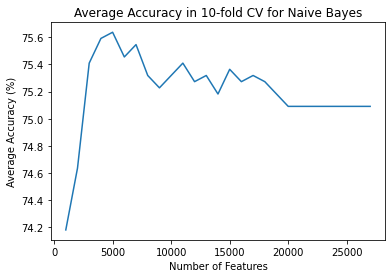

In [ ]:
x =  list(range(1000,28000,1000))
#plt.plot(x, temp)
plt.xlabel('Number of Features')
plt.ylabel('Average åAccuracy (%)')
plt.title('Average Accuracy in 10-fold CV for Naive Bayes')
plt.plot(x, temp)
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/tfidf_features2.jpg')

75.63636363636364


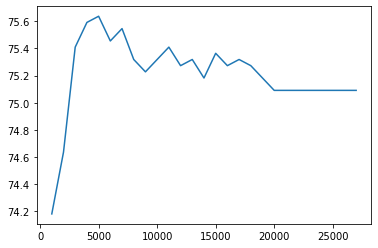

In [ ]:
x =  list(range(1000,28000,1000))
plt.plot(x, temp)
print(max(temp)) # 16000-74.9090
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/tfidf_features1.jpg')

In [ ]:
np.array(temp)[np.argsort(temp)[::-1]] #16000:74.90909091,  15000:74.86363636, 12000:74.81818182

array([75.63636364, 75.59090909, 75.54545455, 75.45454545, 75.40909091,
       75.40909091, 75.36363636, 75.31818182, 75.31818182, 75.31818182,
       75.31818182, 75.27272727, 75.27272727, 75.27272727, 75.22727273,
       75.18181818, 75.18181818, 75.09090909, 75.09090909, 75.09090909,
       75.09090909, 75.09090909, 75.09090909, 75.09090909, 75.09090909,
       74.63636364, 74.18181818])

In [ ]:
np.array(x)[np.argsort(temp)[::-1]]

array([ 5000,  4000,  7000,  6000, 11000,  3000, 15000,  8000, 10000,
       17000, 13000, 12000, 18000, 16000,  9000, 14000, 19000, 27000,
       26000, 20000, 21000, 22000, 23000, 24000, 25000,  2000,  1000])

In [ ]:
# The following steps used 10-fold validation to find out the max features of models
label_encoder = LabelEncoder() 
temp2 = []
for n in range(4000,7000,100): #range(8000,10000,100):
  result = []
  for train_index, test_index in StratifiedKFold(n_splits=10).split(train_short.token,train_short.Class):
    #print(train_index, test_index)
    train = train_short.iloc[train_index]
    valid = train_short.iloc[test_index]
    y_train = label_encoder.fit_transform(train.Class)
    y_valid = label_encoder.fit_transform(valid.Class)
    result.append(PredictBayes(train_short['token'], train.token, valid.token, y_train, y_valid, n))#,X_train,X_valid,y_train,y_valid
  mean_result = np.mean(result)
  print(n,':',mean_result,'\n',result)
  temp2.append(mean_result)
  result = []


4000 : 75.5909090909091 
 [79.54545454545455, 76.81818181818181, 75.0, 76.36363636363637, 75.9090909090909, 79.54545454545455, 73.63636363636363, 74.54545454545455, 69.54545454545455, 75.0]
4100 : 75.95454545454545 
 [80.0, 76.81818181818181, 76.36363636363637, 76.36363636363637, 76.36363636363637, 80.45454545454545, 74.0909090909091, 74.0909090909091, 69.54545454545455, 75.45454545454545]
4200 : 75.59090909090908 
 [80.45454545454545, 76.36363636363637, 75.9090909090909, 75.9090909090909, 76.36363636363637, 80.45454545454545, 72.27272727272728, 74.0909090909091, 69.54545454545455, 74.54545454545455]
4300 : 75.54545454545455 
 [80.0, 76.81818181818181, 75.45454545454545, 75.45454545454545, 75.9090909090909, 80.45454545454545, 72.72727272727273, 74.0909090909091, 69.54545454545455, 75.0]
4400 : 75.77272727272728 
 [80.45454545454545, 76.81818181818181, 76.36363636363637, 75.45454545454545, 75.9090909090909, 80.9090909090909, 73.18181818181819, 73.63636363636363, 69.54545454545455, 75.45

75.95454545454545


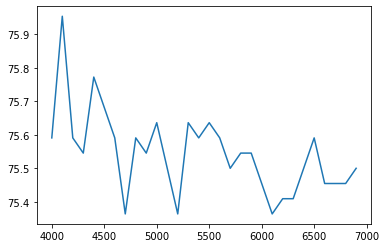

In [ ]:
x2 =  list(range(4000,7000,100))
plt.plot(x2, temp2)
print(max(temp2)) # 16000-74.9090
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/tfidf_features2.jpg')

In [ ]:
np.array(temp2)[np.argsort(temp2)[::-1]] #16000:74.90909091,  15000:74.86363636, 12000:74.81818182

array([75.95454545, 75.77272727, 75.68181818, 75.63636364, 75.63636364,
       75.63636364, 75.59090909, 75.59090909, 75.59090909, 75.59090909,
       75.59090909, 75.59090909, 75.59090909, 75.54545455, 75.54545455,
       75.54545455, 75.54545455, 75.5       , 75.5       , 75.5       ,
       75.5       , 75.45454545, 75.45454545, 75.45454545, 75.45454545,
       75.40909091, 75.40909091, 75.36363636, 75.36363636, 75.36363636])

In [ ]:
np.array(x2)[np.argsort(temp2)[::-1]]

array([3600, 3900, 4000, 4500, 5000, 4800, 4900, 5100, 4100, 4300, 3500,
       6000, 3700, 4400, 5400, 3800, 5300, 5200, 6400, 4600, 5900, 6200,
       6100, 6300, 5500, 5700, 5800, 4700, 4200, 5600])

### Verify Result

In [ ]:
 #pickle.dump(test_short, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/Bay/test_short.p','wb'))
 Algo_naive= pickle.load( open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/Bay/Algo_naive.p','rb'))


In [ ]:
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(train_short.Class)
y_test = label_encoder.fit_transform(test_short.Class)
word_vector_tfidf = TfidfVectorizer(max_features=4100)
word_vector_tfidf.fit(train_short.token) #76.136 data_short
X_train_v = word_vector_tfidf.transform(train_short.token)
X_test_v = word_vector_tfidf.transform(test_short.token)
Algo_naive = naive_bayes.MultinomialNB()
Algo_naive.fit(X_train_v,y_train)

y_predict = Algo_naive.predict(X_test_v)
cmatrix = confusion_matrix(y_test, y_predict)
  
print('max feature =',4100)
print("Naive Bayes Accuracy = ",accuracy_score(y_predict, y_test)*100)
print(cmatrix)

max feature = 4100
Naive Bayes Accuracy =  76.13636363636364
[[20  0  7  0  0  2  1  0  1  3  6]
 [ 0 39  0  0  0  0  0  1  0  0  0]
 [ 5  0 24  0  5  2  1  0  1  0  2]
 [ 0  0  1 39  0  0  0  0  0  0  0]
 [ 0  0  1  5 31  0  0  0  1  0  2]
 [ 0  0  3  0  1 29  5  2  0  0  0]
 [ 2  7  3  0  0  9 14  3  0  2  0]
 [ 0  1  2  0  1  4  0 30  1  0  1]
 [ 1  0  0  1  0  1  2  0 35  0  0]
 [ 0  0  0  0  0  0  0  1  0 39  0]
 [ 0  0  2  1  2  0  0  0  0  0 35]]


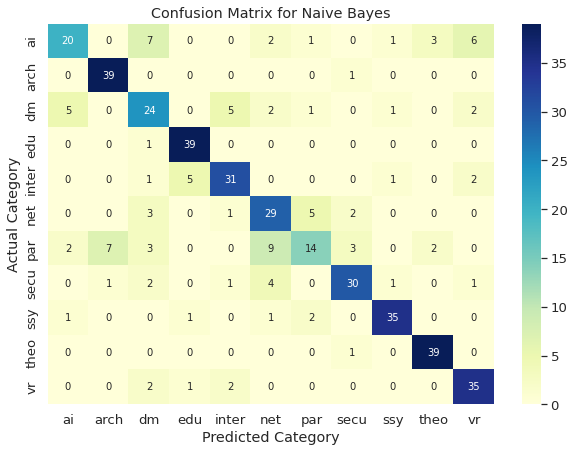

In [ ]:
df_cm = pd.DataFrame(cmatrix, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="YlGnBu") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()
#plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/Bay/NBcmatrix.jpg')

In [ ]:

from sklearn.metrics import top_k_accuracy_score
top_k_accuracy_score(y_test, Algo_naive.predict_proba(X_test_v), k=2)

0.7613636363636364

In [ ]:
top_k_accuracy_score

In [ ]:
print(classification_report(y_test, y_predict, target_names=label_encoder.classes_, digits=3))

              precision    recall  f1-score   support

          ai      0.714     0.500     0.588        40
        arch      0.830     0.975     0.897        40
          dm      0.558     0.600     0.578        40
         edu      0.848     0.975     0.907        40
       inter      0.775     0.775     0.775        40
         net      0.617     0.725     0.667        40
         par      0.609     0.350     0.444        40
        secu      0.811     0.750     0.779        40
         ssy      0.897     0.875     0.886        40
        theo      0.886     0.975     0.929        40
          vr      0.761     0.875     0.814        40

    accuracy                          0.761       440
   macro avg      0.755     0.761     0.751       440
weighted avg      0.755     0.761     0.751       440



In [ ]:
# Verify Top2 accuracy with single labels 
nb_mat = TopKMatrix_manual(2,class_labels,Algo_naive.predict_proba(X_test_v), testing.Class) 
#mat = manualConfusionMatrix1(Algo_naive.predict_proba(X_test_v), testing.Class) 
print(np.diag(nb_mat).sum()/np.sum(nb_mat))
nb_mat

0.925


[[37, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 34, 0, 4, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 39, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 1],
 [0, 0, 2, 0, 0, 35, 2, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 2, 34, 2, 0, 0, 0],
 [0, 0, 1, 0, 0, 2, 0, 36, 0, 0, 1],
 [1, 0, 0, 1, 0, 1, 1, 0, 36, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0],
 [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 37]]

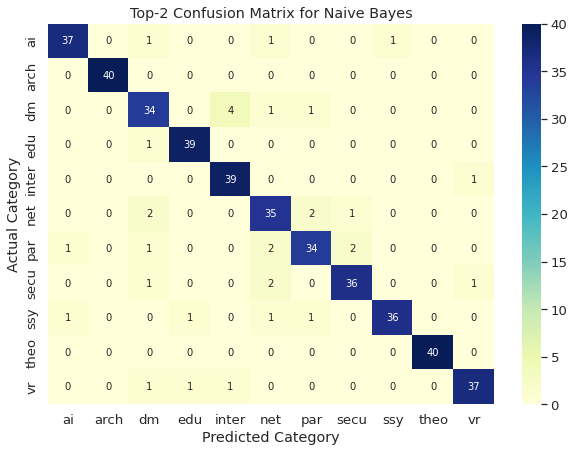

In [ ]:
df_cm = pd.DataFrame(mat, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="YlGnBu") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Top-2 Confusion Matrix for Naive Bayes')
#plt.show()
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/Bay/NBcmatrix2.jpg')

In [ ]:
  # Verify Top2 accuracy with Multiply labels
mat2 = manualConfusionMatrix2(Algo_naive.predict_proba(X_test_v), testing.Categories) 
print(np.diag(mat2).sum()/np.sum(mat2))
mat2

0.9295454545454546


[[37, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 34, 0, 4, 1, 1, 0, 0, 0, 0],
 [0, 0, 1, 39, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 36, 2, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 1, 34, 2, 0, 0, 0],
 [0, 0, 1, 0, 0, 2, 0, 36, 0, 0, 1],
 [1, 0, 0, 1, 0, 1, 1, 0, 36, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0],
 [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 38]]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score
acu = accuracy_score(y_test, y_predict)  # 准确率
recall = recall_score(y_test, y_predict, average="macro")  # 召回率
print(recall)
from sklearn.metrics import f1_score
f1_score(y_test, y_predict, average='micro')

0.7613636363636364


0.7613636363636364

In [ ]:
Algo_naive.predict_proba

0.8486363636363636

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, top_k_accuracy_score
print("Average Accuracy for training set：%.3f" %Algo_naive.score(X_train_v,y_train))
print("Average Accuracy for test set：%.3f" %Algo_naive.score(X_test_v,y_test))
print("Recall for model: %.3f" %recall_score(y_test, y_predict, average="macro"))
print("Top-2 accuracy: %.3f" %top_k_accuracy_score(y_test, Algo_naive.predict_proba(X_test_v), k=2))

Average Accuracy for training set：0.849
Average Accuracy for test set：0.761
Recall for model: 0.761
Top-2 accuracy: 0.925


### Other code

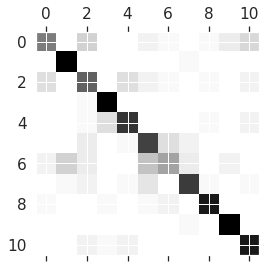

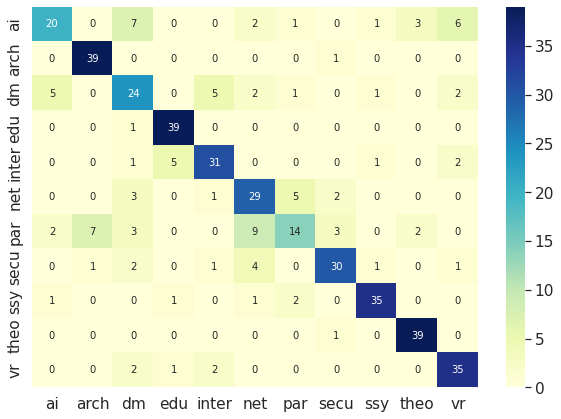

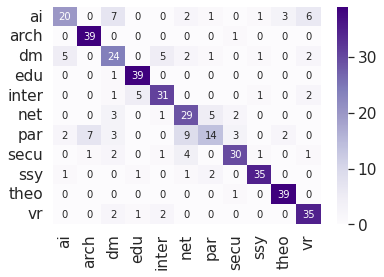

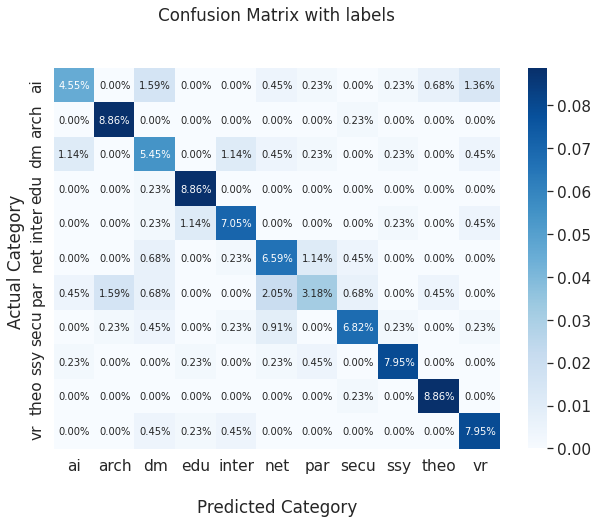

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cmatrix, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="YlGnBu") # font size "YlOrRd"

plt.show()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="Purples") # font size "PuBuGn"

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(cmatrix/np.sum(cmatrix), annot=True, annot_kws={"size": 10},fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.show()

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

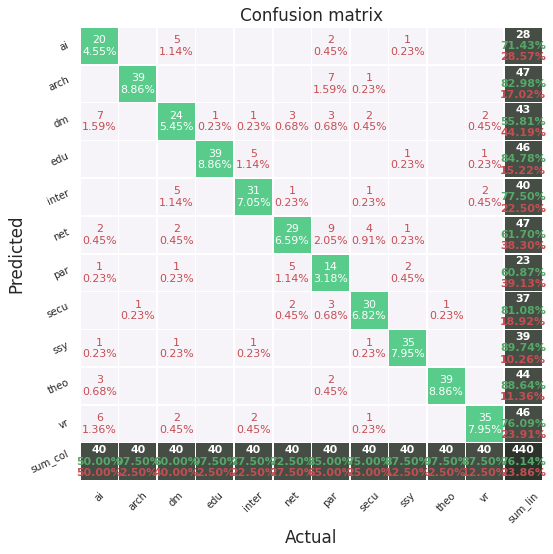

In [ ]:
cla = ["Artificial Intelligence","Architecture","Data Mining","Educational Technology","Human-Computer Interaction","Computer Networks & Wireless Communication","Parallel Distributed System","Computer Security \& Cryptography","Software Systems","Theoretical Computer Science","Computer Vision \& Graphic"]
class_labels = ["ai","arch","dm","edu","inter","net","par","secu","ssy","theo","vr"]
df_cm = pd.DataFrame(cmatrix, index=range(0, 11), columns=range(0, 11))
from pretty_confusion_matrix import pp_matrix_from_data
from pretty_confusion_matrix import pp_matrix
df_cm = pd.DataFrame(cmatrix, index=cla2, columns=cla2)
# colormap: see this and choose your more dear
cmap = 'PuRd'
pmatrix = pp_matrix(df_cm, cmap="PuRd")

## Topic Clustering with Weighted TF-IDF


### Function


In [ ]:
# 把词换成cluster id from kmean
def translate(a, d):
  if a.shape[0]==0:
    print(a)
  n = np.zeros(a.shape[0], dtype=int) - 1
  for i in range(a.shape[0]):
    if a[i] in d:
      n[i] = d[a[i]]
  return n
#
def to_input_vec(token, mappcer):
  global N_CLUSTER
  vec = np.zeros(N_CLUSTER, dtype=int)
  temp = translate(token if type(token) is np.ndarray else np.array(token), mapper)
  cluster_id, counts = np.unique(temp, return_counts=True)
  if cluster_id[0] == -1:
    cluster_id = cluster_id[1:]
    counts = counts[1:]
  vec[cluster_id] = counts
  return vec

In [ ]:
def get_train_tfidf_df(X_train,freq):
  CV = CountVectorizer(tokenizer=lambda x:x, lowercase=False)
  counts_mat = CV.fit_transform(X_train)#.toarray()
  #print(CV.get_feature_names()) 
  train_tfidf_df = pd.DataFrame.sparse.from_spmatrix( counts_mat, columns=CV.get_feature_names())
  train_tfidf_df = train_tfidf_df.iloc[:,np.where(train_tfidf_df.sum(axis=0)>freq)[0]]
  return train_tfidf_df

In [ ]:
def get_trainIDF(Y_train,train_tfidf_df):
  trainclass = {element:None for element in Y_train.unique()}
  for key in trainclass:
    # class index #默认从0开始 #取出xtrain里面相对应每个class的index
    trainclass[key] = np.where(Y_train.values==key)[0]
    # filter #取所有列
  M =(train_tfidf_df!=0).sum(0).values
  #M2 = (train_tfidf_df).sum(0).values
  # 包括word的文档数
  #print(len(M))
  #print(M)
  #print(M2)
  N = train_tfidf_df.shape[0]
  #print(N) # 文章总数 all xtrain document
  # tf*IDF
  # trainclass xtrain相对应每个class的不同doc的index
  # train_tfidf_df 每个word在每个doc相对应的次数
  class_idf = {}
  for cl in trainclass:
    #取出了每个word在相对应的class的相对应出现的次数
    mat = train_tfidf_df.iloc[trainclass[cl]].sparse.to_coo().T # row:word col:doc
    B = mat.shape[1] #该class的文档总数
    contain = mat != 0 #判断是否含有该词
    A_vec = contain.sum(1) #该词在该class出现文档的次数
    words_count = mat.sum(1) #该词在该class出现的总数
    class_idf[cl] = np.log(words_count / words_count.sum() + 1) * np.log((N / M) * (A_vec / B) + 1) #返回每个词在每个class的idf #+1 smoothing(不出负数)
    # log(n/m)*log(n/m)*log(a/b+1)  #log(w/t)*log(n/m)*|log(a/b)|)
  # 每个词的tfidf
  
  return class_idf

In [ ]:
CV = CountVectorizer(tokenizer=lambda x:x, lowercase=False)
def number_cluster_kmean(N_CLUSTER,X_train,X_test,Y_train,Y_test,trainIDF):
  #N_CLUSTER = 4
  global mapper
  
  kmeans = KMeans(n_clusters=N_CLUSTER, n_init=10,random_state=RAMDOM_STATE).fit(trainIDF)
  mapper = { trainIDF.index[i]:kmeans.labels_[i] for i in range(trainIDF.shape[0]) }
  X_train_c = pd.DataFrame([*map(lambda s:to_input_vec(s,mapper),X_train.values)])
  X_test_c = pd.DataFrame([*map(lambda s:to_input_vec(s,mapper),X_test.values)])
  label_encoder = LabelEncoder()
  y_train = label_encoder.fit_transform(Y_train)
  y_test = label_encoder.fit_transform(Y_test)
  logreg = LogisticRegression(max_iter=3000)
  logreg.fit(X_train_c,y_train)
  y_pred = logreg.predict(X_test_c)

  accuracy = accuracy_score(y_pred, y_test)*100
  #cmatrix = confusion_matrix(y_test, y_pred)
 
  return accuracy

In [ ]:
def checkCat1(PredLabel, TrueLabel, returncat = False):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  sortprob = np.argsort(PredLabel)[::-1]  # 按照顺序排列
  for prob in range(2):                   # 检查前三
    if labels[sortprob[prob]] == TrueLabel :#and  PredLabel[sortprob[0]]*0.5 <= PredLabel[sortprob[prob]]:
      return True if not returncat else sortprob[prob]
  return -1
def manualConfusionMatrix1(PredLabels, TrueLabels):  
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = checkCat1(PredLabel, TrueLabels[i], True)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      true = labels.index(TrueLabels[i])
      mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat

### Build model

In [ ]:
train_short = trainProcess[['token','Class']].copy() 
test_short = testing[['token','Class']].copy() 

In [ ]:
CV = CountVectorizer(tokenizer=lambda x:x, lowercase=False)

In [ ]:
Y_train = train_short.Class
X_train = train_short.token

Y_test = test_short.Class
X_test = test_short.token

In [ ]:
train_tfidf_df = get_train_tfidf_df(X_train,10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
class_idf = get_trainIDF(Y_train,train_tfidf_df)
col = [*class_idf.keys()]
trainIDF = pd.DataFrame(np.hstack([class_idf[cl] for cl in col]),columns=col,index=train_tfidf_df.columns.values)

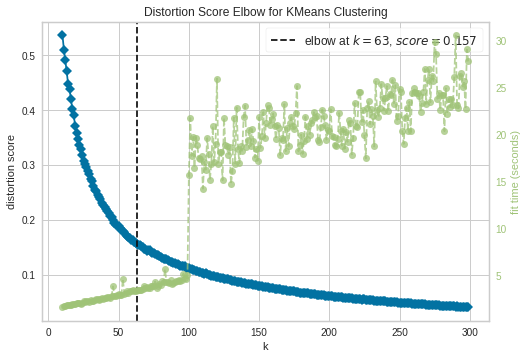

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=RAMDOM_STATE)
visualizer = KElbowVisualizer(model, k=(10,300))#, metric='calinski_harabasz', timings=False)
visualizer.fit(trainIDF)        # Fit the data to the visualizer
#visualizer.show()  
visualizer.show(outpath="/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/kmean&LR/elbow.jpg")

https://www.kaggle.com/code/mooventhchiyan/kmeans-hirerchical-testing


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
N_CLUSTER = 63
kmeans = KMeans(n_clusters=N_CLUSTER, n_init=10,random_state=RAMDOM_STATE).fit(trainIDF)
mapper = { trainIDF.index[i]:kmeans.labels_[i] for i in range(trainIDF.shape[0]) }
X_train_c = pd.DataFrame([*map(lambda s:to_input_vec(s,mapper),X_train.values)])
X_test_c = pd.DataFrame([*map(lambda s:to_input_vec(s,mapper),X_test.values)])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(Y_train)
y_test = label_encoder.fit_transform(Y_test)
logreg = LogisticRegression(random_state=RAMDOM_STATE,multi_class='multinomial',solver="saga", max_iter=10000)
logreg.fit(X_train_c,y_train)
y_pred = logreg.predict(X_test_c)
  
print(str(N_CLUSTER))
print(str(N_CLUSTER)+': n_cluster = '+str(np.unique(kmeans.labels_)))
accuracy = accuracy_score(y_pred, y_test)*100
print("Logistic Accuracy = ",accuracy)
k_mat = confusion_matrix(y_test, y_pred)
print(k_mat)


63
63: n_cluster = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Logistic Accuracy =  69.31818181818183
[[18  0  9  0  0  3  0  2  0  4  4]
 [ 0 33  0  0  0  0  4  2  0  0  1]
 [ 8  1 20  0  4  1  1  1  0  0  4]
 [ 0  0  1 37  0  0  0  0  1  0  1]
 [ 1  0  2  6 27  0  0  0  2  0  2]
 [ 1  2  2  0  1 28  3  3  0  0  0]
 [ 0  3  3  0  0  8 21  3  1  1  0]
 [ 1  1  1  0  1  6  7 22  0  1  0]
 [ 0  0  0  0  2  1  1  1 35  0  0]
 [ 2  0  2  0  0  0  1  0  0 35  0]
 [ 5  0  2  1  2  0  0  1  0  0 29]]


In [ ]:
testing.iloc[test_short.iloc[list(set(np.where(y_test==7)[0])&set(np.where(y_pred==5)[0]))].index]

,filename,title,Class,Categories,token
320,998,An SDN-Enabled Proactive Defense Framework for...,secu,[secu],"[internet, iot, become, truly, ubiquitous, dom..."
257,883,Towards Fine-grained Network Security Forensic...,secu,[secu],"[diagnose, network, security, issue, tradition..."
179,971,Multi-Agent Reinforcement Learning-Based Buffe...,secu,[secu],"[proposes, multi, agent, reinforcement, buffer..."
372,796,On the Safety of IoT Device Physical Interacti...,secu,[secu],"[emerge, internet, iot, platform, increase, fu..."
309,853,ACE: Asynchronous and Concurrent Execution of ...,secu,[secu],"[smart, contract, programmable, decentralize, ..."
375,828,Concurrency and Privacy with Payment-Channel N...,secu,[secu],"[permissionless, blockchains, protocol, bitcoi..."


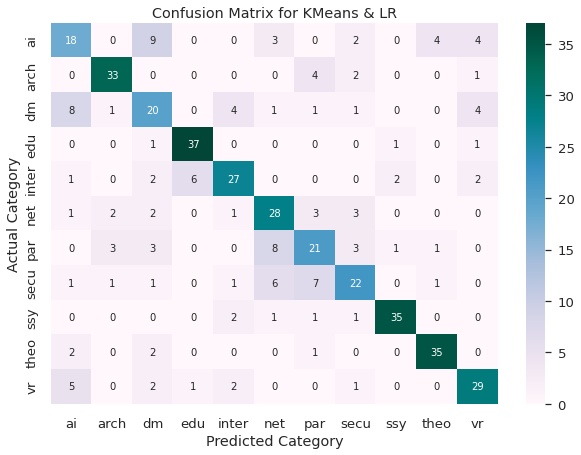

In [ ]:
df_cm = pd.DataFrame(cmatrix, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="PuBuGn") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for KMeans & LR')
#plt.show()
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/kmean&LR/KMeans.jpg')

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_,digits=3))

              precision    recall  f1-score   support

          ai      0.500     0.450     0.474        40
        arch      0.825     0.825     0.825        40
          dm      0.476     0.500     0.488        40
         edu      0.841     0.925     0.881        40
       inter      0.730     0.675     0.701        40
         net      0.596     0.700     0.644        40
         par      0.553     0.525     0.538        40
        secu      0.629     0.550     0.587        40
         ssy      0.897     0.875     0.886        40
        theo      0.854     0.875     0.864        40
          vr      0.707     0.725     0.716        40

    accuracy                          0.693       440
   macro avg      0.692     0.693     0.691       440
weighted avg      0.692     0.693     0.691       440



0.8772727272727273


Text(0.5, 1.0, 'Confusion Matrix for KMeans & LR in Top-2')

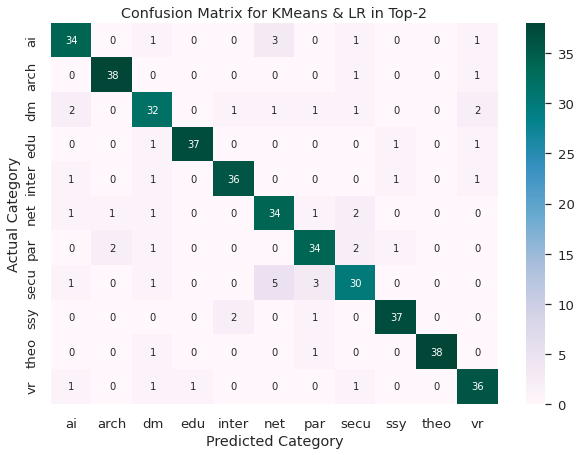

In [ ]:
# Verify Top2 accuracy with single labels
k_mat2 =  TopKMatrix_manual(2, class_labels, logreg.predict_proba(X_test_c), testing.Class)  
# k_mat = manualConfusionMatrix1(logreg.predict_proba(X_test_c), testing.Class) 
print(np.diag(k_mat2).sum()/np.sum(k_mat2))
df_cm = pd.DataFrame(k_mat2, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="PuBuGn") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for KMeans & LR in Top-2')
#plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/kmean&LR/KMeans2.jpg')

In [ ]:
logreg.predict_proba(X_test_c)

array([[5.80582318e-005, 4.68517766e-001, 3.61635160e-005, ...,
        6.67049252e-004, 2.24863602e-012, 8.84992046e-009],
       [3.77223876e-104, 3.62005920e-102, 1.16620151e-111, ...,
        3.81372533e-117, 5.35252420e-138, 1.36001655e-122],
       [5.56518987e-001, 2.92147444e-004, 2.49698829e-001, ...,
        3.81485851e-004, 2.09878310e-012, 1.26143338e-001],
       ...,
       [5.18051399e-001, 1.65454438e-006, 4.68850826e-001, ...,
        3.61558179e-010, 7.02681687e-014, 1.25410796e-002],
       [1.48381346e-006, 1.94195684e-005, 5.89958132e-004, ...,
        1.36731404e-006, 9.33318994e-016, 3.43284566e-015],
       [5.14967335e-025, 2.02792266e-027, 8.06452448e-028, ...,
        1.11337385e-024, 1.80266475e-036, 7.28864592e-026]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, top_k_accuracy_score
print("Accuracy for training set：%.3f" %logreg.score(X_train_c, y_train))
print("Accuracy for test set：%.3f" %logreg.score(X_test_c, y_test))
print("F1-Score for model: %.3f" %f1_score(y_test, y_pred, average='micro'))
print("Recall for model: %.3f" %recall_score(y_test, y_pred, average="macro"))
print("Top-2 accuracy: %.3f" %top_k_accuracy_score(y_test, logreg.predict_proba(X_test_c), k=2))

Accuracy for training set：0.846
Accuracy for test set：0.693
Recall for model: 0.693
Top-2 accuracy: 0.877


In [ ]:
visualizer.show()  

### Other Code (used for analyse)

In [ ]:
logreg.predict_proba(X_test_c.iloc[320:321])

array([[3.00530103e-06, 1.71810036e-04, 8.19520707e-06, 2.37501779e-14,
        2.62696936e-09, 8.74701050e-01, 1.21335534e-01, 3.77521649e-03,
        5.18460373e-06, 1.07331981e-09, 5.74909645e-17]])

In [ ]:
logreg.predict_proba(X_test_c.iloc[193:194])

array([[1.70819647e-02, 1.35675367e-01, 6.19787872e-03, 3.24113923e-10,
        3.74402152e-05, 5.37844762e-01, 2.06972475e-01, 9.60340545e-02,
        8.23328216e-05, 7.37211011e-05, 4.18018404e-09]])

In [ ]:
np.sum([1.70819647e-02, 1.35675367e-01, 6.19787872e-03, 3.24113923e-10,
        3.74402152e-05, 5.37844762e-01, 2.06972475e-01, 9.60340545e-02,
        8.23328216e-05, 7.37211011e-05, 4.18018404e-09])

1.0000000005621978

In [ ]:
testing.iloc[320].title

'An SDN-Enabled Proactive Defense Framework for DDoS Mitigation in IoT Networks'

In [ ]:
len(np.unique(testing.iloc[320].token))

916

In [ ]:
print([(l,k) for k,l in sorted([(j,i) for i,j in Counter(testing.iloc[193].token).items()], reverse=True)][:20])
print([(l,k) for k,l in sorted([(j,i) for i,j in Counter(testing.iloc[320].token).items()], reverse=True)][:20])

[('attack', 121),
 ('attacker', 119),
 ('defense', 105),
 ('strategy', 102),
 ('server', 93),
 ('propose', 62),
 ('DDoS', 55),
 ('honeypot', 53),
 ('iot', 52),
 ('signal', 50),
 ('network', 47),
 ('framework', 44),
 ('defender', 40),
 ('payoff', 39),
 ('belief', 37),
 ('proactive', 33),
 ('message', 32),
 ('MTD', 32),
 ('sender', 30),
 ('model', 30)]

In [ ]:
#print(logreg.coef_[0])
print('ai class coef:')
print('the first 10')
print(np.argsort(logreg.coef_[0])[::-1][:10])
print(logreg.coef_[0][np.argsort(logreg.coef_[0])[::-1][:10]])
print('the last 10')
print(np.argsort(logreg.coef_[0])[:10])
print(logreg.coef_[0][np.argsort(logreg.coef_[0])[:10]])
print('-------')
print('net class coef')
print('the first 10')
print(np.argsort(logreg.coef_[5])[::-1][:10])
print(logreg.coef_[5][np.argsort(logreg.coef_[1])[::-1][:10]])
print('the last 10')
print(np.argsort(logreg.coef_[5])[:10])
print(logreg.coef_[5][np.argsort(logreg.coef_[1])[:10]])
print('--------')
#print(logreg.coef_[2])
print('secu class coef')
print('the first 10')
print(np.argsort(logreg.coef_[7])[::-1][:10])
print(logreg.coef_[7][np.argsort(logreg.coef_[2])[::-1][:10]])
print('the last 10')
print(np.argsort(logreg.coef_[7])[:10])
print(logreg.coef_[7][np.argsort(logreg.coef_[2])[:10]]) 
# ai-net: 29,33,54,20, - 21,

ai class coef:
the first 10
[55 29 47 33 54 20 52 11 31 14]
[0.02854141 0.02692262 0.0169825  0.01581825 0.01542935 0.01148338
 0.01121524 0.01099991 0.0105845  0.00935   ]
the last 10
[30 17 13 15 21 32 51  6 45 48]
[-0.03471225 -0.03184906 -0.01638921 -0.0157261  -0.01449883 -0.0106946
 -0.01066595 -0.0086358  -0.00747239 -0.00657846]
-------
net class coef
the first 10
[34  7 10 55  1 21 47 11 31 26]
[ 0.00035445  0.02460357  0.00679991  0.00341645  0.03034319  0.00123576
 -0.00401174 -0.03474835  0.00031469  0.00211214]
the last 10
[29 40 33 54 13  3 20 19 37 58]
[-0.00555314 -0.03234538  0.01952732  0.00222995 -0.01905201  0.03057951
  0.00901853  0.01593863 -0.0052017   0.0154976 ]
--------
secu class coef
the first 10
[ 1 31 62 13 49 14 37 29 45 40]
[-0.0347992  -0.03205516 -0.01607798 -0.01466528 -0.02995538 -0.00786469
  0.00864346 -0.0165307  -0.00298579 -0.00993058]
the last 10
[54 34 52 19 60 57 17 55 25  3]
[ 0.01982182 -0.00782583 -0.00357134  0.00281581 -0.02315499  0.01

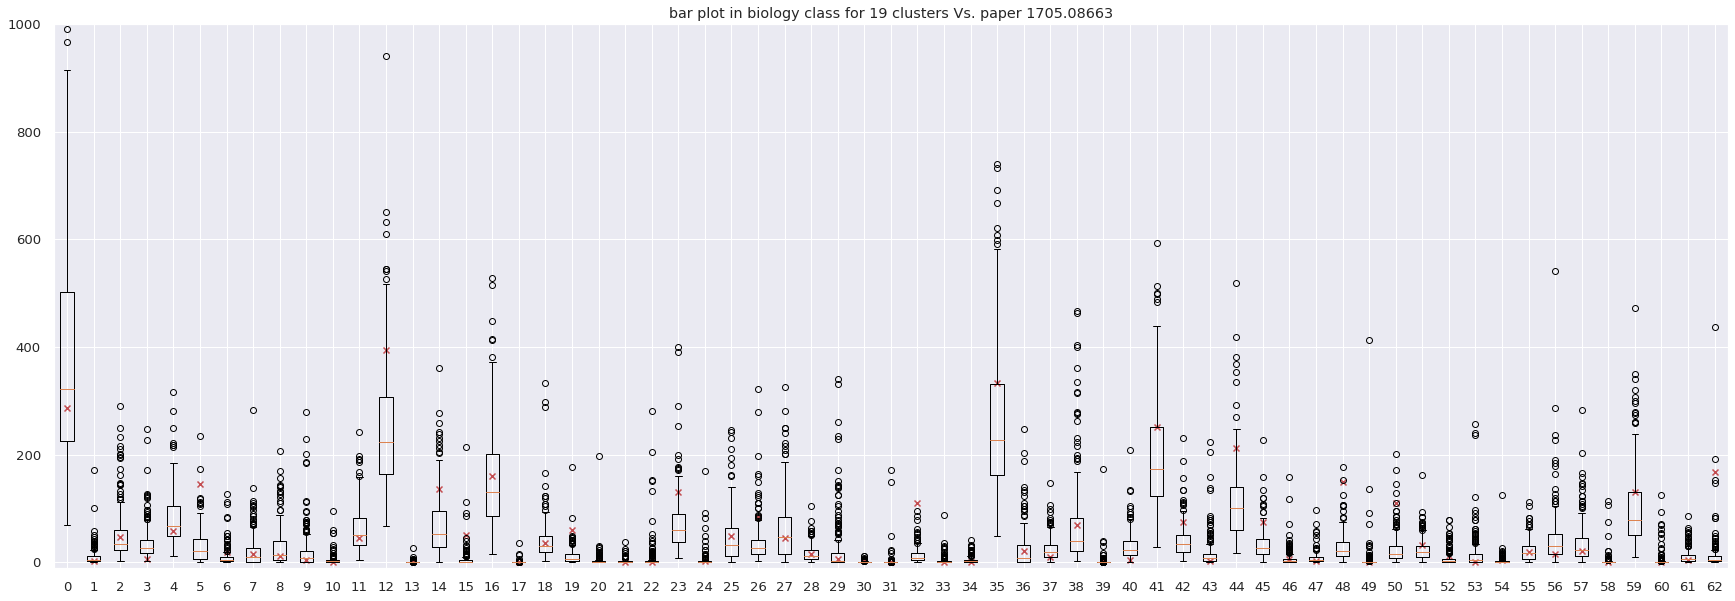

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()

bp = ax.boxplot(X_train_c.iloc[np.where(Y_train=='ai')[0]].T)
#bp = ax.boxplot(X_train_c.iloc[np.delete(np.where(Y_train=='b')[0],13)].T)
ax.scatter([*range(1,64)],X_test_c.iloc[193:194],marker = 'x', color = 'r')
plt.ylim([-10,1000])
#plt.xlim(0,64)
#plt.xlim([49,101])
plt.title('bar plot in biology class for 19 clusters Vs. paper 1705.08663')
ax.set(xticklabels=[*range(0,63)])
plt.show()

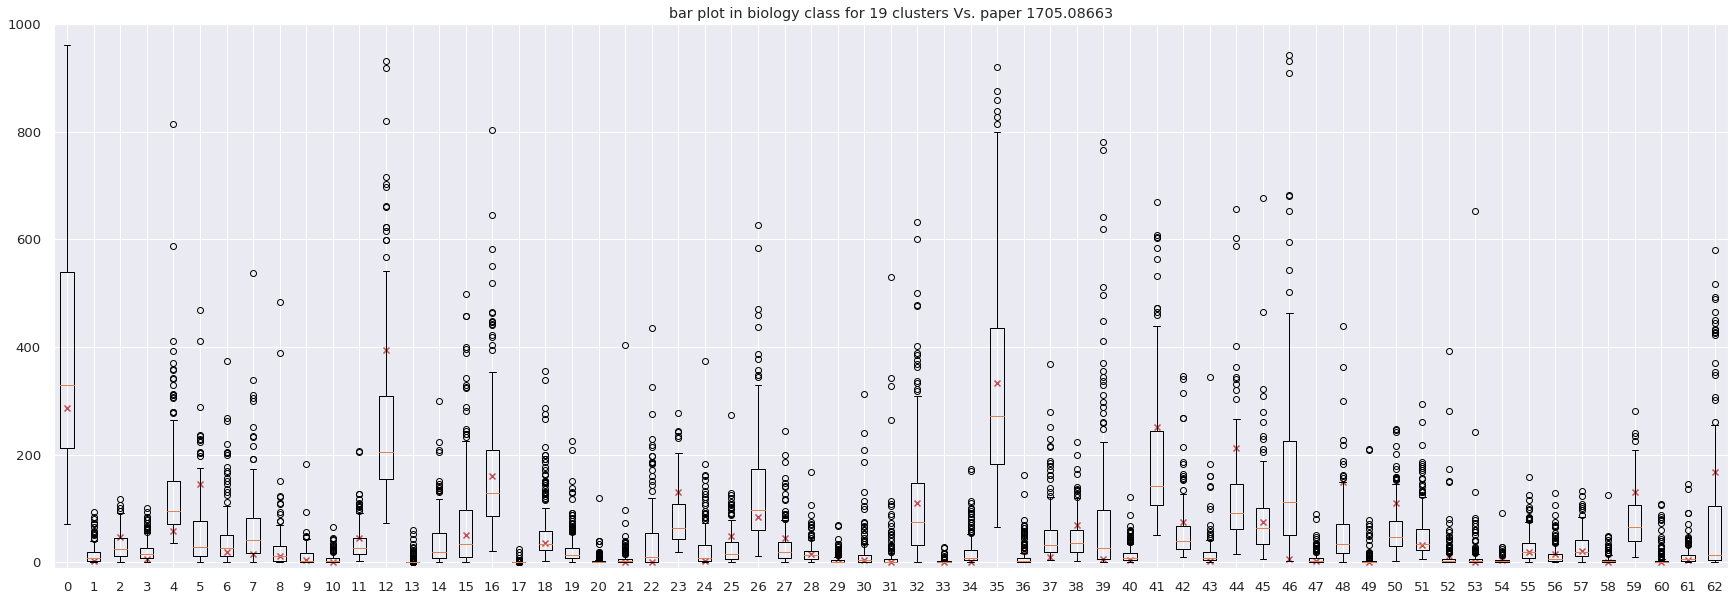

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()

bp = ax.boxplot(X_train_c.iloc[np.where(Y_train=='net')[0]].T)
#bp = ax.boxplot(X_train_c.iloc[np.delete(np.where(Y_train=='b')[0],13)].T)
ax.scatter([*range(1,64)],X_test_c.iloc[193:194],marker = 'x', color = 'r')
plt.ylim([-10,1000])
#plt.xlim(0,64)
#plt.xlim([49,101])
plt.title('bar plot in biology class for 19 clusters Vs. paper 1705.08663')
ax.set(xticklabels=[*range(0,63)])
plt.show()

In [ ]:
ai1 = pd.DataFrame(index=X_test.iloc[193:194].values[0])
ai1['cluster'] = translate(ai1.index,mapper)
ai1 = ai1.iloc[np.where(ai1.cluster != -1)[0]].sort_values('cluster')
#f2b_2.to_csv('/content/drive/Shareddrives/My Dessertation/meeting/1:Dec Wed/f2b_2.csv')
print('unique word in cluster 4 in 19clusters:')
print(np.unique(ai1[ai1.cluster == 32].index))
print()
print('words in cluster 4 in 19clusters:')
print(ai1[ai1.cluster == 32].index.value_counts()[:20])
#34  7 10 55  1 21 47 11 31 26

unique word in cluster 4 in 19clusters:
['application' 'communication' 'compute' 'device' 'resource']

words in cluster 4 in 19clusters:
communication    90
device           11
compute           4
application       3
resource          2
dtype: int64


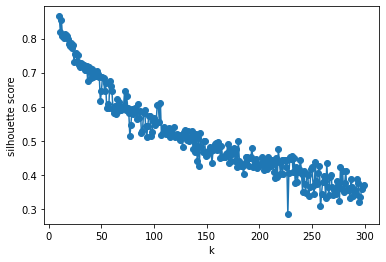

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import xlrd

Scores = []  # 存放轮廓系数
for k in range(10, 300):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(np.array(trainIDF))
    Scores.append(silhouette_score(np.array(trainIDF), estimator.labels_, metric='euclidean'))
X = range(10, 300)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.plot(X, Scores, 'o-')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
data_scaled= sc.fit_transform(trainIDF)
num_cluster= range(10,300)
culster_error=[]

for cluster in num_cluster:
    model= KMeans(n_clusters=cluster,n_init=10)
    model.fit(data_scaled)
    label= model.labels_
    centroids=model.cluster_centers_
    culster_error.append(model.inertia_)
cluster_df= pd.DataFrame({"num_cluster": num_cluster, "error": culster_error})
# Elbow Curve
plt.plot(cluster_df["num_cluster"],cluster_df["error"],marker="*")
plt.show()


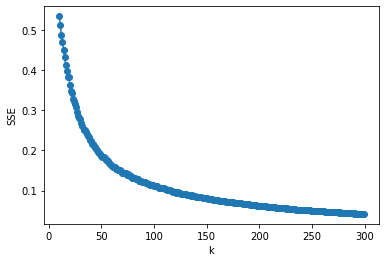

In [ ]:
X = range(10, 300)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 50  40  70 350 130 190  30 290 320 180 340 360  20 230  60 240 220 210
 280  90 270 330 370 300 390 250 150 380 110 200 170 310  80 260 120 140
 160 100  10] 
 y: [75.45454545 73.63636364 72.27272727 71.81818182 70.90909091 70.45454545
 70.45454545 70.45454545 70.         70.         69.54545455 69.54545455
 69.54545455 69.54545455 69.09090909 69.09090909 69.09090909 69.09090909
 68.63636364 68.18181818 67.72727273 67.72727273 67.72727273 67.27272727
 67.27272727 66.81818182 66.81818182 66.81818182 66.81818182 66.36363636
 66.36363636 66.36363636 65.90909091 65.90909091 65.45454545 65.45454545
 64.09090909 63.63636364 51.81818182]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [48 52 44 58 50 46 56 42 54 40] 
 max11_y: [78.63636364 76.36363636 76.36363636 75.45454545 75.45454545 75.45454545
 74.09090909 74.09090909 73.63636364 73.63636364]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [69 65 67 77 83 81 75 71 79 73] 
 max22_y: [74.54545455 73.63636364 70.90909091 70.45454545 69.09090909 68.63636364
 68.63636364 67.72727273 66.81818182 65.90909091]
[75.45454545454545, 75.45454545454545, 78.63636363636364, 74.54545454545455] 
 [50, 50, 48, 69] 
 48
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 50  60  40 260 320 360  30 280 380 100 390 340 180 290  70 120  80  90
 350  20 160 150 200 300 170 330 370 220 190 250 210 310 110 230 240 270
 130  10 140] 
 y: [75.90909091 71.81818182 71.36363636 70.90909091 70.45454545 70.
 70.         69.09090909 68.63636364 68.63636364 68.18181818 68.18181818
 68.18181818 67.72727273 67.27272727 67.27272727 66.81818182 66.81818182
 66.81818182 66.81818182 66.36363636 66.36363636 66.36363636 66.36363636
 65.90909091 65.90909091 65.90909091 65.45454545 65.         65.
 64.09090909 64.09090909 63.63636364 63.63636364 63.63636364 63.63636364
 60.90909091 59.54545455 58.63636364]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [48 50 52 46 42 44 58 54 40 56] 
 max11_y: [78.18181818 75.90909091 74.54545455 73.63636364 73.63636364 73.18181818
 72.72727273 72.27272727 71.36363636 69.54545455]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [79 65 77 75 69 81 67 71 83 73] 
 max22_y: [74.09090909 72.27272727 70.         70.         70.         69.54545455
 69.54545455 68.63636364 66.81818182 66.81818182]
[75.9090909090909, 75.9090909090909, 78.18181818181819, 74.0909090909091] 
 [50, 50, 48, 79] 
 48
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [290 380 390 220  50 260 180 200 370 250 210 320 280 330 360 350 310 190
 230 340  70 270  60  30  40 170 300 240  90  20  80 150 110 160 120 140
 100 130  10] 
 y: [73.18181818 73.18181818 72.27272727 72.27272727 71.81818182 71.81818182
 71.36363636 71.36363636 70.45454545 70.45454545 70.         70.
 70.         70.         69.54545455 69.54545455 69.09090909 69.09090909
 69.09090909 68.63636364 68.63636364 68.18181818 67.72727273 67.72727273
 67.72727273 67.27272727 67.27272727 66.36363636 66.36363636 65.90909091
 65.45454545 63.63636364 63.63636364 63.18181818 62.72727273 62.27272727
 60.90909091 59.54545455 58.63636364]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [292 282 290 286 298 296 294 280 284 288] 
 max11_y: [74.09090909 74.09090909 73.18181818 72.72727273 71.81818182 70.90909091
 70.         70.         68.63636364 68.18181818]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [73 65 71 67 63 69 77 79 75 81] 
 max22_y: [71.81818182 71.36363636 70.45454545 70.         69.54545455 69.09090909
 66.36363636 65.90909091 65.90909091 65.45454545]
[73.18181818181819, 73.18181818181819, 74.0909090909091, 71.81818181818181] 
 [290, 290, 292, 73] 
 292
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 30 390  50  40 340 330 370 270 300  20 320 350 360 310 280 170 250 260
 290 380 210 160  60 240 150 230 190 130 100  70 140 180  80 120 220 110
  90 200  10] 
 y: [77.27272727 72.72727273 72.27272727 71.81818182 71.36363636 71.36363636
 70.90909091 70.45454545 70.         70.         70.         70.
 69.54545455 69.54545455 69.09090909 69.09090909 68.63636364 68.18181818
 68.18181818 67.72727273 67.72727273 67.27272727 66.81818182 66.81818182
 66.81818182 66.81818182 66.36363636 65.90909091 65.45454545 65.45454545
 65.45454545 65.         65.         64.09090909 64.09090909 64.09090909
 63.18181818 62.72727273 54.09090909]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [30 38 36 32 22 28 26 34 24 20] 
 max11_y: [77.27272727 76.36363636 74.54545455 74.54545455 73.18181818 72.72727273
 72.72727273 72.27272727 70.90909091 70.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [73 71 67 83 81 69 79 75 77 85] 
 max22_y: [71.81818182 71.36363636 70.45454545 70.         69.54545455 69.09090909
 66.81818182 66.36363636 65.         64.09090909]
[77.27272727272727, 77.27272727272727, 77.27272727272727, 71.81818181818181] 
 [30, 30, 30, 73] 
 30
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [190 380 270 280  50 260 200 340  40 300 290 230  80 100 240 360 320 310
 350 220 110  60 390 180 330  70 370 140 210 250  90 160 150  30 120 130
 170  20  10] 
 y: [74.54545455 73.18181818 73.18181818 72.72727273 72.72727273 72.72727273
 72.27272727 72.27272727 72.27272727 71.81818182 71.81818182 71.36363636
 71.36363636 71.36363636 70.90909091 70.90909091 70.45454545 70.45454545
 70.45454545 70.45454545 70.         70.         70.         70.
 70.         69.54545455 69.54545455 69.09090909 69.09090909 68.63636364
 67.72727273 66.81818182 66.81818182 66.81818182 66.36363636 65.90909091
 65.         64.54545455 57.72727273]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [190 188 194 196 180 198 184 192 186 182] 
 max11_y: [74.54545455 72.72727273 70.45454545 70.         70.         69.54545455
 69.54545455 69.09090909 69.09090909 67.72727273]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [64 72 80 68 76 66 70 74 82 78] 
 max22_y: [72.72727273 71.81818182 71.36363636 71.36363636 70.45454545 70.45454545
 69.54545455 69.09090909 67.27272727 67.27272727]
[74.54545454545455, 74.54545454545455, 74.54545454545455, 72.72727272727273] 
 [190, 190, 190, 64] 
 190
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 30 220  50  20 350  40 230 100 200 340  70  80 300 110 310 280 240 170
 250 320 360 260  60 130  90 390 150 180 270 330 370 290 380 210 160 190
 140 120  10] 
 y: [72.72727273 70.90909091 70.45454545 70.45454545 70.         69.54545455
 69.54545455 69.09090909 69.09090909 69.09090909 68.63636364 68.63636364
 68.18181818 68.18181818 67.72727273 67.72727273 67.72727273 67.72727273
 67.27272727 67.27272727 67.27272727 66.81818182 66.81818182 66.36363636
 66.36363636 66.36363636 66.36363636 66.36363636 66.36363636 66.36363636
 66.36363636 65.45454545 65.         65.         64.09090909 64.09090909
 63.63636364 62.72727273 53.63636364]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

max11_x: [30 34 24 28 32 20 26 38 36 22] 
 max11_y: [72.72727273 72.27272727 72.27272727 71.81818182 71.36363636 70.45454545
 70.         69.54545455 69.54545455 67.27272727]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [76 64 66 62 80 70 68 78 72 74] 
 max22_y: [70.45454545 70.45454545 70.         69.09090909 68.63636364 68.63636364
 68.18181818 67.72727273 66.36363636 65.90909091]
[72.72727272727273, 72.72727272727273, 72.72727272727273, 70.45454545454545] 
 [30, 30, 30, 76] 
 30
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 50 360 350  90 380 390 240 180 330 260 130 340 110 310 320 370  80 210
  70 250 280 100 150 120  40  20  30 200 270 170 220  60 230 290 190 160
 300 140  10] 
 y: [72.27272727 70.90909091 70.90909091 70.45454545 70.45454545 69.54545455
 69.09090909 69.09090909 69.09090909 68.63636364 68.18181818 68.18181818
 67.72727273 67.72727273 67.27272727 67.27272727 67.27272727 67.27272727
 67.27272727 67.27272727 66.81818182 66.81818182 66.81818182 66.36363636
 66.36363636 65.90909091 65.90909091 65.90909091 65.90909091 65.45454545
 65.45454545 65.45454545 65.45454545 65.45454545 64.54545455 64.09090909
 64.09090909 59.54545455 57.72727273]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [50 48 46 58 44 54 42 40 52 56] 
 max11_y: [72.27272727 70.         70.         69.09090909 68.63636364 67.27272727
 66.36363636 66.36363636 65.         62.72727273]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [64 78 62 66 80 70 76 68 74 72] 
 max22_y: [70.         69.54545455 68.63636364 68.18181818 67.27272727 67.27272727
 66.81818182 66.81818182 64.09090909 64.09090909]
[72.27272727272728, 72.27272727272728, 72.27272727272728, 70.0] 
 [50, 50, 50, 64] 
 50
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [ 50 340  60  40 350 380 370 360  70 200 330 320 310 270 110 250 160 300
 290 190  30 100 390 180 260 170 140 120  80 280 240 130 220 230  90 150
 210  20  10] 
 y: [73.18181818 71.36363636 71.36363636 70.45454545 70.         70.
 68.63636364 68.63636364 68.63636364 68.18181818 68.18181818 68.18181818
 68.18181818 68.18181818 67.72727273 67.72727273 67.72727273 67.72727273
 67.27272727 67.27272727 67.27272727 66.81818182 66.81818182 66.81818182
 66.81818182 66.36363636 66.36363636 66.36363636 66.36363636 66.36363636
 65.45454545 65.         64.54545455 64.54545455 64.09090909 63.63636364
 63.18181818 62.27272727 52.27272727]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [50 56 54 58 46 44 40 52 48 42] 
 max11_y: [73.18181818 71.81818182 71.81818182 70.90909091 70.90909091 70.45454545
 70.45454545 68.63636364 68.18181818 66.36363636]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [69 67 77 75 71 65 73 63 81 79] 
 max22_y: [74.09090909 71.81818182 70.45454545 70.45454545 69.09090909 69.09090909
 67.72727273 67.27272727 65.45454545 65.45454545]
[73.18181818181819, 73.18181818181819, 73.18181818181819, 74.0909090909091] 
 [50, 50, 50, 69] 
 69
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [310 290 350 390 340 300 250 360 240 320  20  40  50 330  30 280 230 210
 220 380  60 190 170 370 270 200 260 180  70 130  90 140 160 150 100  80
 110 120  10] 
 y: [69.54545455 69.54545455 69.09090909 67.72727273 67.72727273 67.72727273
 67.72727273 67.27272727 67.27272727 67.27272727 66.81818182 66.36363636
 66.36363636 66.36363636 65.90909091 65.45454545 65.         65.
 64.54545455 64.54545455 64.09090909 64.09090909 64.09090909 63.63636364
 63.63636364 63.18181818 63.18181818 62.27272727 61.36363636 60.90909091
 60.90909091 60.90909091 60.90909091 60.45454545 60.         60.
 58.18181818 57.27272727 55.45454545]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [310 314 318 304 300 316 302 312 306 308] 
 max11_y: [69.54545455 68.63636364 67.72727273 67.72727273 67.72727273 67.27272727
 66.81818182 66.36363636 65.90909091 63.63636364]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [77 69 67 71 59 63 73 61 65 75] 
 max22_y: [65.90909091 65.90909091 65.90909091 65.45454545 65.45454545 64.54545455
 63.18181818 62.27272727 61.36363636 60.90909091]
[69.54545454545455, 69.54545454545455, 69.54545454545455, 65.9090909090909] 
 [310, 310, 310, 77] 
 310
------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase 

x: [370 330 390  60 380 300 290 150 190 240 260 310 270 250 230 320 280 110
 220 340  50  30  40 350 360 100 200 160 180 120  80  70  20  90 130 170
 210 140  10] 
 y: [70.90909091 70.90909091 70.         70.         70.         69.54545455
 69.09090909 68.63636364 68.18181818 68.18181818 68.18181818 68.18181818
 67.72727273 67.72727273 67.72727273 67.72727273 67.27272727 67.27272727
 67.27272727 67.27272727 67.27272727 66.81818182 66.81818182 66.81818182
 66.36363636 65.90909091 65.90909091 65.45454545 65.45454545 64.09090909
 64.09090909 64.09090909 63.63636364 63.18181818 62.72727273 62.72727273
 62.72727273 62.27272727 51.81818182]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max11_x: [368 370 364 374 376 372 378 362 366 360] 
 max11_y: [71.36363636 70.90909091 70.90909091 70.45454545 69.09090909 68.63636364
 67.27272727 67.27272727 66.81818182 66.36363636]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


max22_x: [60 68 64 66 62 76 78 70 72 74] 
 max22_y: [70.         69.09090909 68.18181818 67.72727273 66.36363636 65.
 64.54545455 64.09090909 63.18181818 62.27272727]
[70.9090909090909, 70.9090909090909, 71.36363636363636, 70.0] 
 [370, 370, 368, 60] 
 368
------------


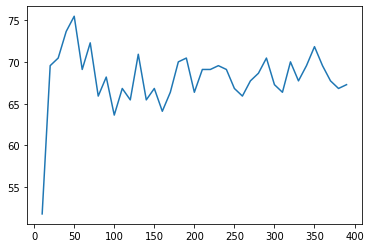

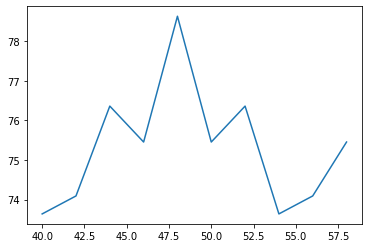

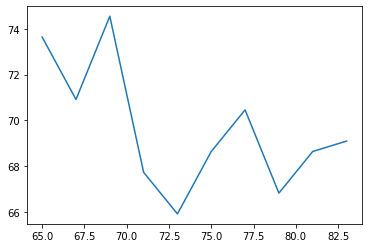

<Figure size 432x288 with 0 Axes>

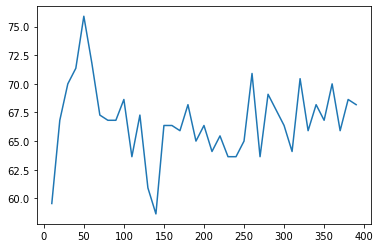

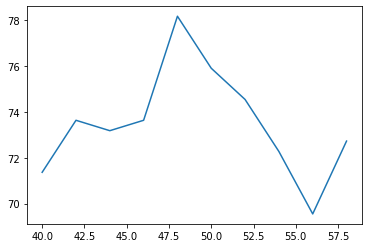

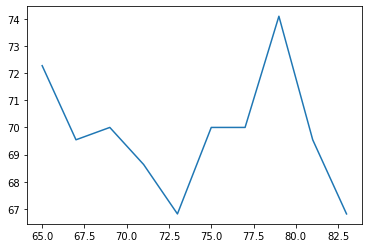

<Figure size 432x288 with 0 Axes>

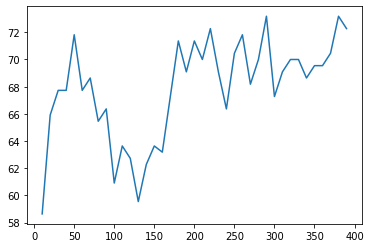

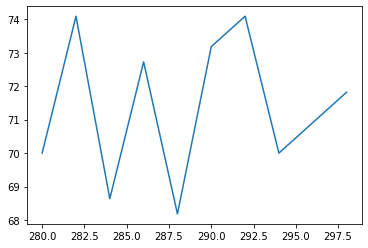

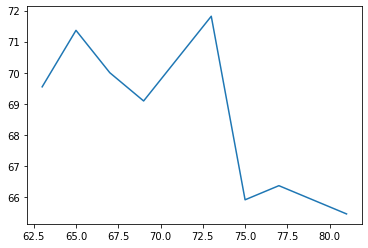

<Figure size 432x288 with 0 Axes>

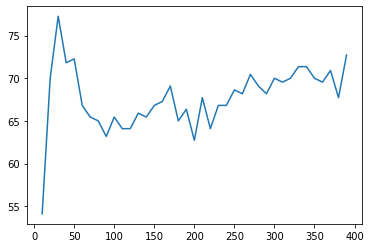

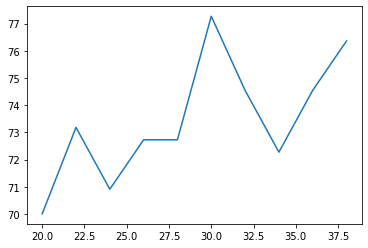

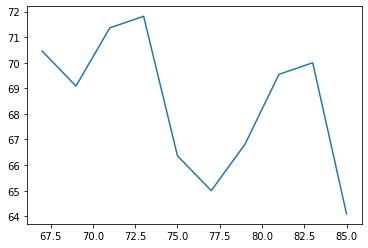

<Figure size 432x288 with 0 Axes>

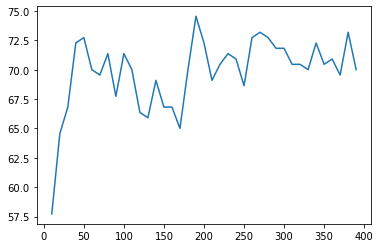

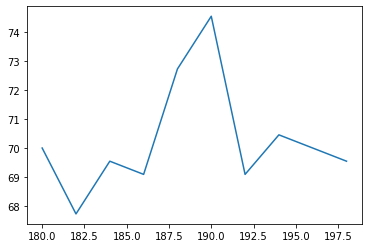

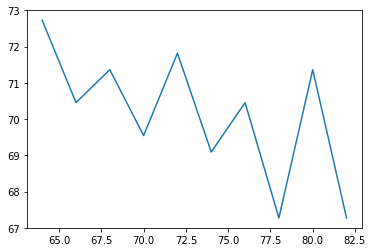

<Figure size 432x288 with 0 Axes>

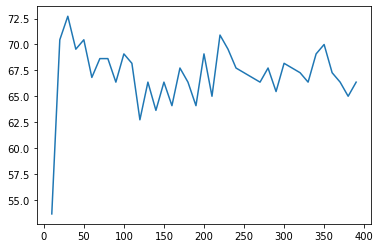

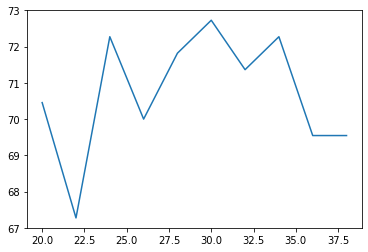

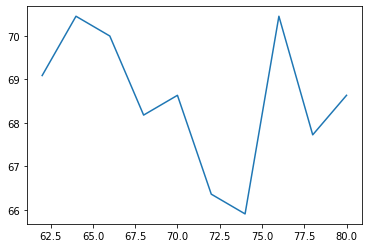

<Figure size 432x288 with 0 Axes>

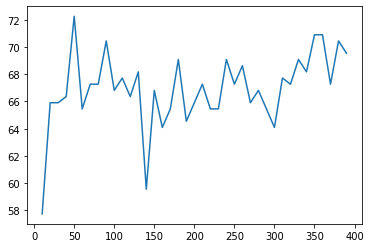

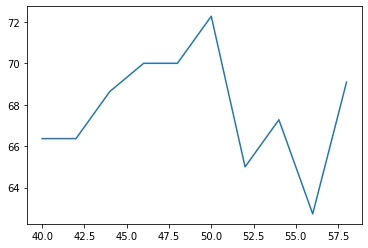

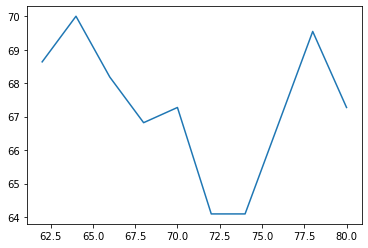

<Figure size 432x288 with 0 Axes>

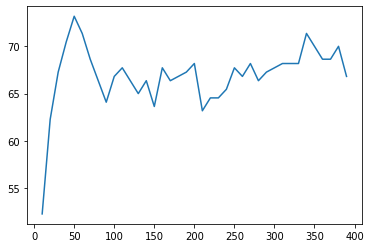

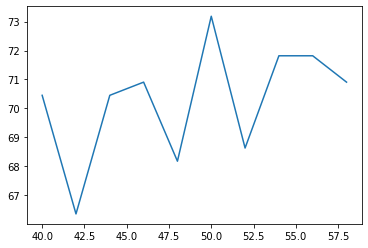

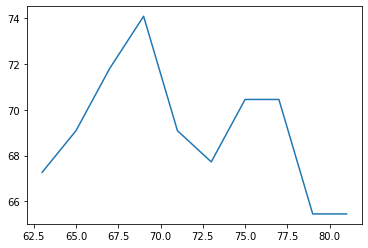

<Figure size 432x288 with 0 Axes>

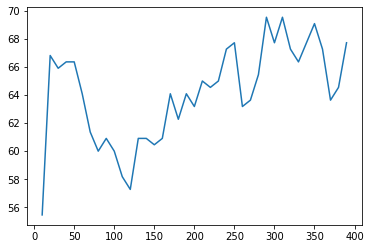

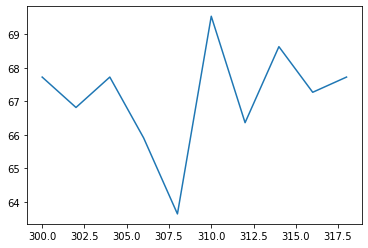

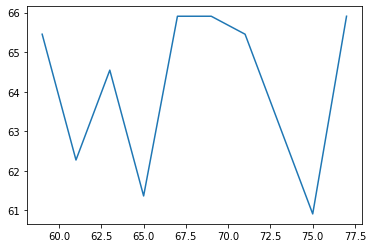

<Figure size 432x288 with 0 Axes>

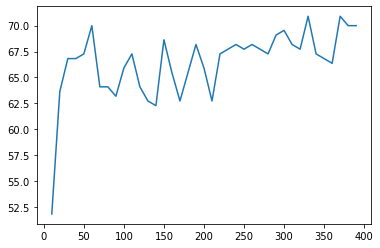

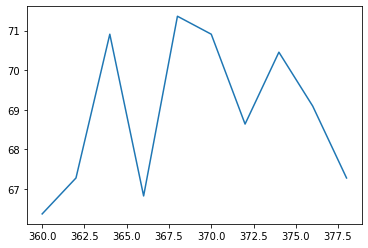

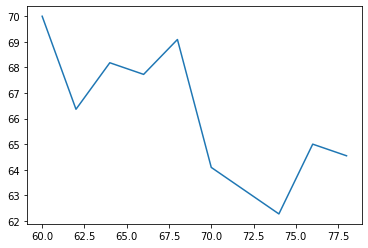

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
t = []
label_encoder = LabelEncoder() 
for train_index, test_index in StratifiedKFold(n_splits=10).split(train_short.token,train_short.Class):
    #print(train_index, test_index)
    train = train_short.iloc[train_index]
    valid = train_short.iloc[test_index]
    X_train = train.token
    X_valid = valid.token
    Y_train = train.Class
    Y_valid = valid.Class
    #y_train = label_encoder.fit_transform(Y_train)
    #y_valid = label_encoder.fit_transform(valid.Class)
    
    counts_mat = CV.fit_transform(X_train)#.toarray() 
    train_tfidf_df = pd.DataFrame.sparse.from_spmatrix( counts_mat, columns=CV.get_feature_names())   
    train_tfidf_df = train_tfidf_df.iloc[:,np.where(train_tfidf_df.sum(axis=0)>10)[0]] 
    trainclass = {element:None for element in Y_train.unique()}
    for key in trainclass:
       # class index #默认从0开始 #取出xtrain里面相对应每个class的index
      trainclass[key] = np.where(Y_train.values==key)[0]
    M =(train_tfidf_df!=0).sum(0).values
    M2 = (train_tfidf_df).sum(0).values
    N = train_tfidf_df.shape[0]
    #print(N) # 文章总数 all xtrain document
    # tf*IDF
    # trainclass xtrain相对应每个class的不同doc的index
    # train_tfidf_df 每个word在每个doc相对应的次数
    class_idf = {}
    for cl in trainclass:
      #取出了每个word在相对应的class的相对应出现的次数
      mat = train_tfidf_df.iloc[trainclass[cl]].sparse.to_coo().T # row:word col:doc
      B = mat.shape[1] #该class的文档总数
      contain = mat != 0 #判断是否含有该词
      A_vec = contain.sum(1) #该词在该class出现文档的次数
      words_count = mat.sum(1) #该词在该class出现的总数
      class_idf[cl] = np.log(words_count / words_count.sum() + 1) * np.log((N / M) * (A_vec / B) + 1) #返回每个词在每个class的idf #+1 smoothing(不出负数)
      # log(n/m)*log(n/m)*log(a/b+1)  #log(w/t)*log(n/m)*|log(a/b)|)  

    # 每个词的tfidf
    col = [*class_idf.keys()]
    trainIDF = pd.DataFrame(np.hstack([class_idf[cl] for cl in col]),columns=col,index=train_tfidf_df.columns.values)
    trainIDF  

    plotx1 = list(range(10,400,10)) #130/160/220 73.6363 122/126-74.54
    ploty1 = []
    # n_init=10 # logistic regresion
    for N_CLUSTER in plotx1:
      ploty1.append(number_cluster_kmean(N_CLUSTER,X_train,X_valid,Y_train,Y_valid,trainIDF))
    plt.plot(plotx1, ploty1)

    # plotting the points
    #np.array(temp)[np.argsort(temp)[::-1]][0]
    max1_y = np.array(ploty1)[np.argsort(ploty1)[::-1]][0]
    max2_y = np.array(ploty1)[np.argsort(ploty1)[::-1]][0]
    max1_x = np.array(plotx1)[np.argsort(ploty1)[::-1]][0]
    max2_x = np.array(plotx1)[np.argsort(ploty1)[::-1]][0]
    print('x:', np.array(plotx1)[np.argsort(ploty1)[::-1]], '\n', 'y:', np.array(ploty1)[np.argsort(ploty1)[::-1]])
    plt.figure()

    plotx2 = list(range(int(max1_x)-10,int(max1_x)+10,2)) #130/160/220 73.6363 122/126-74.54
    ploty2 = []
    # n_init=10 # logistic regresion
    for N_CLUSTER in plotx2:
      ploty2.append(number_cluster_kmean(N_CLUSTER,X_train,X_valid,Y_train,Y_valid,trainIDF))
    plt.plot(plotx2, ploty2)
    max11_y = np.array(ploty2)[np.argsort(ploty2)[::-1]][0]
    #print('max11_y:', np.array(ploty2)[np.argsort(ploty2)[::-1]])
    max11_x = np.array(plotx2)[np.argsort(ploty2)[::-1]][0]
    #print('max11_x:', np.array(plotx2)[np.argsort(ploty2)[::-1]])
    print('max11_x:', np.array(plotx2)[np.argsort(ploty2)[::-1]], '\n', 'max11_y:', np.array(ploty2)[np.argsort(ploty2)[::-1]])
    plt.figure()


    plotx3 = list(range(int(max2_y)-10,int(max2_y)+10,2)) #130/160/220 73.6363 122/126-74.54
    ploty3 = []
    # n_init=10 # logistic regresion
    for N_CLUSTER in plotx3:
      ploty3.append(number_cluster_kmean(N_CLUSTER,X_train,X_valid,Y_train,Y_valid,trainIDF))
    plt.plot(plotx3, ploty3)
    max22_y = np.array(ploty3)[np.argsort(ploty3)[::-1]][0]
    max22_x = np.array(plotx3)[np.argsort(ploty3)[::-1]][0]
    print('max22_x:', np.array(plotx3)[np.argsort(ploty3)[::-1]], '\n', 'max22_y:', np.array(ploty3)[np.argsort(ploty3)[::-1]])
    plt.figure()

    
    comparey = [max1_y, max2_y, max11_y, max22_y]
    comparex = [max1_x, max2_x, max11_x, max22_x]
    maxnum = np.array(comparex)[np.argsort(comparey)[::-1]][0]
    print(comparey,'\n',comparex,'\n',maxnum)
    print('------------')
    t.append(maxnum)
    plt.figure()
#73 130 360 71 114 76 346 76 368 71

## Labeled LDA


### Function

In [ ]:

def checkCat( PredLabel, TrueLabel, returncat = False):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  sortprob = np.argsort(PredLabel)[::-1]  
  for prob in range(2):                   
    if labels[sortprob[prob]] == TrueLabel :
      return True if not returncat else sortprob[prob]
  return -1
def manualConfusionMatrix(PredLabels, TrueLabels):
  labels = ['ai', 'arch', 'dm', 'edu', 'inter', 'net', 'par', 'secu', 'ssy','theo', 'vr']
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = checkCat(PredLabel, TrueLabels[i], True)
    #print(i,':',cat)
    if cat:
      ind = labels.index(cat)
      mat[ind][ind]+= 1
    else:
      pred = labels.index(PredLabel[0 if PredLabel[0][0] != 'common_topic' else 1][0])
      #print('pred:',pred)
      true = labels.index(TrueLabels[i][0])
      #print('true:',true)
      mat[true][pred] += 1
  return mat

In [ ]:
def TopKcheckCat(K, labels, PredLabel, TrueLabel, returncat = False):
  sortprob = np.argsort(PredLabel)[::-1]  # Sorted by order
  for prob in range(K):                   # check first k
    if labels[sortprob[prob]] == TrueLabel :#and  PredLabel[sortprob[0]]*0.5 <= PredLabel[sortprob[prob]]:
      return True if not returncat else sortprob[prob]
  return -1
def TopKMatrix_manual(K, labels, PredLabels, TrueLabels):  
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = TopKcheckCat(K,labels, PredLabel, TrueLabels[i], True)
    if cat != -1:
      mat[cat][cat]+= 1
    else:
      true = labels.index(TrueLabels[i])
      mat[true][np.argsort(PredLabel)[-1]] += 1
  return mat

In [ ]:
def checkCat_LLDA(K, PredLabel, TrueLabel, returncat = False):
  pred = 0 if PredLabel[0][0] != 'common_topic' else 1   # Check the first label whether "Common Topic" (to makesure the largest probability is not common topic)
  if PredLabel[pred][0] in TrueLabel:                    # If the prediction is in the true label 如果prediction在true label里面
    return True if not returncat else PredLabel[pred][0] # reture True
  for i in range(pred+1,min(K,len(PredLabel))):          # Otherwise, check the first K 
    if PredLabel[i][0] in TrueLabel:
      return True if not returncat else PredLabel[i][0]
  return False
def manualTopK_LLDA(K, PredLabels, TrueLabels, labels):
  mat = [[0]*len(labels) for _ in range(len(labels))]
  for i,PredLabel in enumerate(PredLabels):
    cat = checkCat_LLDA(K, PredLabel, TrueLabels[i], True)
    if cat:
      ind = labels.index(cat)
      mat[ind][ind]+= 1
    else:
      pred = labels.index(PredLabel[0 if PredLabel[0][0] != 'common_topic' else 1][0])
      true = labels.index(TrueLabels[i][0])
      mat[true][pred] += 1

  return mat

### Build Model

In [ ]:
train_short = trainProcess.copy() 
train_short = train_short[['token','Class']]
train_short['token'] = train_short['token'].apply(' '.join)

str2list2(train_short,'Class')
train_short

,token,Class
0,immutable append distribute ledger blockchain ...,[secu]
1,infographic widely adopt communicate numerical...,[vr]
2,spatial traffic location detection gathering a...,[dm]
3,sensor essential component computer mobile dev...,[secu]
4,regulate srl predictable instrumental complica...,[edu]
...,...,...
2195,kinematics analysis model beam pump BPU propos...,[ai]
2196,ghost artifact misalignment challenge construc...,[vr]
2197,teacher quality opportunity professional devel...,[inter]
2198,web simulation WBS increasingly educator deliv...,[edu]


In [ ]:
import sys
sys.path.append('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA')
import labeled_lda as llda

In [ ]:
train_documents = list(zip(train_short.token,train_short.Class))

In [ ]:
llda_model = llda.LldaModel(labeled_documents=train_documents, alpha_vector=0.01)

In [ ]:
interation = []
perplexity = []
delta_beta = []
while True:
    print("iteration %s sampling..." % (llda_model.iteration + 1))
    llda_model.training(1)
    print("after iteration: %s, perplexity: %s" % (llda_model.iteration, llda_model.perplexity()))
    interation.append(llda_model.iteration)
    perplexity.append(llda_model.perplexity())
    print("delta beta: %s" % llda_model.delta_beta)
    delta_beta.append(llda_model.delta_beta)
    if llda_model.is_convergent(method="beta", delta=0.01):
        break

iteration 1 sampling...
gibbs sample count:  7539098
after iteration: 1, perplexity: 3101.049246021114
delta beta: 1.6513011178646253
iteration 2 sampling...
gibbs sample count:  7539098
after iteration: 2, perplexity: 3083.316254056042
delta beta: 1.5577929856808914
iteration 3 sampling...
gibbs sample count:  7539098
after iteration: 3, perplexity: 3042.5819751610766
delta beta: 1.5591919717331344
iteration 4 sampling...
gibbs sample count:  7539098
after iteration: 4, perplexity: 2960.9321154695713
delta beta: 1.7220670203978496
iteration 5 sampling...
gibbs sample count:  7539098
after iteration: 5, perplexity: 2812.7839922539292
delta beta: 2.086660155913674
iteration 6 sampling...
gibbs sample count:  7539098
after iteration: 6, perplexity: 2585.5071708115083
delta beta: 2.5207895406009295
iteration 7 sampling...
gibbs sample count:  7539098
after iteration: 7, perplexity: 2360.5491044059067
delta beta: 2.5644506220085086
iteration 8 sampling...
gibbs sample count:  7539098
after

KeyboardInterrupt: ignored

### Verify Result

In [ ]:
 #pickle.dump(llda_model, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda_model.p','wb'))
 #llda_model = pickle.load( open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/mmodel/model7/LDA/llda_model.p','rb'))

In [ ]:
 llda_model = pickle.load( open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda_model.p','rb'))

In [ ]:
delta_beta = pickle.load( open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/delta_beta_b.p','rb'))
iteration = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/interation_b.p','rb'))
perplexity = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/perplexity_b.p','rb'))


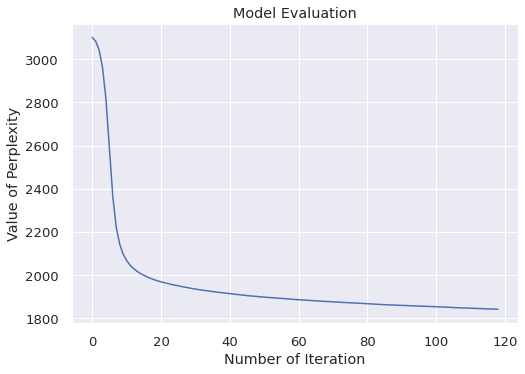

In [ ]:
plt.xlabel('Number of Iteration')
plt.ylabel('Value of Perplexity')
plt.title('Model Evaluation')
plt.plot([*range(llda_model.iteration)],llda_model.all_perplexities)
#plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/Perplexity.jpg')

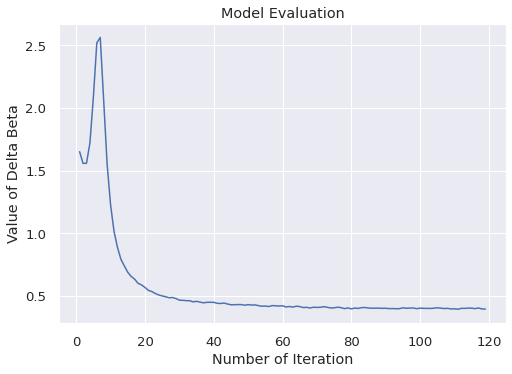

In [ ]:
plt.xlabel('Number of Iteration')
plt.ylabel('Value of Delta Beta')
plt.title('Model Evaluation')
plt.plot(interation,delta_beta)
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/delta_beta.jpg')


In [ ]:
print(llda_model)
test_short = testing.copy()
test_short = test_short[['token','Class']]
test_short


Labeled-LDA Model:
	K = 11
	M = 2200
	T = 25245
	WN = 7539098
	LN = 0
	alpha = 0.01
	eta = 0.001
	perplexity = 1842.3700450460215
	


,token,Class
0,"[harvest, deployment, microcontrollers, consta...",arch
1,"[online, blend, instructor, increasingly, feed...",edu
2,"[computational, evaluate, neural, network, usu...",ai
3,"[compress, representation, compression, standa...",theo
4,"[popularity, adoption, smart, phone, greatly, ...",secu
...,...,...
435,"[empirical, technique, software, engineering, ...",ssy
436,"[internet, iot, grid, hierarchical, storage, s...",par
437,"[series, data, collection, chronological, obse...",dm
438,"[hybrid, effective, address, insufficient, res...",par


In [ ]:
test_short['token'] = test_short['token'].apply(' '.join)
test_short['pred'] = np.nan

In [ ]:
llda_result = []
for i in range(len(test_short)):
  result = llda_model.inference(document=test_short.token.iloc[i], iteration=100, times=10)
  llda_result.append(result)
  test_short['pred'].iloc[i] = result[0][0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# pickle.dump(llda_result, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda_result_b.p','wb'))
# pickle.dump(test_short, open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/test_short_b.p','wb'))
llda_result = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda_result_b.p','rb'))
test_short = pickle.load(open('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/test_short_b.p','rb'))

In [ ]:
test_short

,token,Class,pred
0,harvest deployment microcontrollers constant s...,arch,arch
1,online blend instructor increasingly feedback ...,edu,edu
2,computational evaluate neural network usually ...,ai,common_topic
3,compress representation compression standard c...,theo,theo
4,popularity adoption smart phone greatly stimul...,secu,secu
...,...,...,...
435,empirical technique software engineering autom...,ssy,ssy
436,internet iot grid hierarchical storage storage...,par,net
437,series data collection chronological observati...,dm,common_topic
438,hybrid effective address insufficient resource...,par,par


In [ ]:
import copy
test_short2 = test_short.copy()
test_short2['pred'] = np.nan

In [ ]:
common_count = 0
for i in range(len(test_short2)): 
  #result = llda_model.inference(document=test_short2.clean.iloc[i], iteration=100, times=10)
  #llda_result_corn.append(result)
  result = llda_result[i]
  if result[0][0] == 'common_topic':
    test_short2['pred'].iloc[i] = result[1][0]
    common_count+=1
  else:
    test_short2['pred'].iloc[i] = result[0][0]
print(common_count)

88


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_short2.Class)
y_pred = label_encoder.fit_transform(test_short2.pred)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_pred, y_test)*100)

[[22  0  7  0  0  1  2  1  0  0  7]
 [ 0 38  0  0  0  0  1  1  0  0  0]
 [ 5  0 24  0  4  2  1  0  2  0  2]
 [ 0  0  1 39  0  0  0  0  0  0  0]
 [ 0  0  1  6 30  0  0  0  1  0  2]
 [ 0  0  2  0  1 30  4  3  0  0  0]
 [ 4  7  2  0  1  8 15  1  0  2  0]
 [ 0  1  1  0  1  4  0 31  1  0  1]
 [ 1  0  0  0  1  1  2  0 35  0  0]
 [ 1  0  0  0  0  0  0  1  0 38  0]
 [ 0  0  2  1  3  0  0  0  0  0 34]]
76.36363636363637


In [ ]:
# Build an array of probabilty without "common topic"
llda_array = np.empty([len(llda_result),len(llda_result[0])-1], dtype = float)
for i in range(len(llda_result)):
  for j in range(len(llda_result[i])):
    if llda_result[i][j][0] == "common_topic":
      continue
    else:
      llda_array[i][class_labels.index(llda_result[i][j][0])] = llda_result[i][j][1]

0.7636363636363637


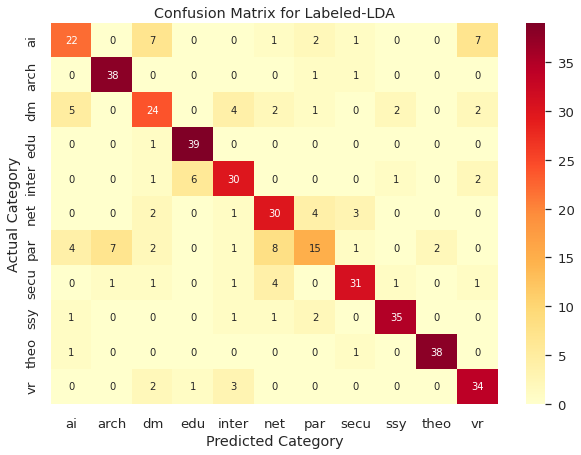

In [ ]:
# Top-1
l_mat1 = TopKMatrix_manual(1, class_labels, llda_array, testing.Class)
print(np.diagonal(np.array(l_mat1)).sum()/440)
df_cm = pd.DataFrame(l_mat1, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="YlOrRd") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for Labeled-LDA')
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda1.jpg')

In [ ]:
top_k_accuracy_score(y_test, llda_array, k=1)

0.7636363636363637

0.884090909090909


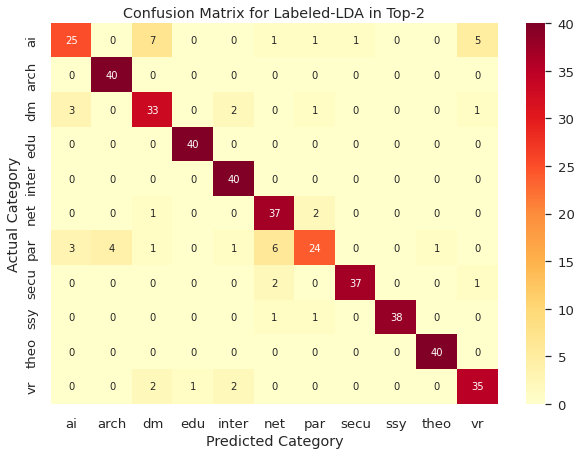

In [ ]:
# Top-2
l_mat2 = TopKMatrix_manual(2, class_labels, llda_array, testing.Class)
print(np.diagonal(np.array(l_mat2)).sum()/440)
df_cm = pd.DataFrame(l_mat2, class_labels, class_labels)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10},cmap="YlOrRd") # font size
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix for Labeled-LDA in Top-2')
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/LDA/llda2.jpg')

In [ ]:
top_k_accuracy_score(y_test, llda_array, k=2)

0.884090909090909

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=3))

              precision    recall  f1-score   support

          ai      0.667     0.550     0.603        40
        arch      0.826     0.950     0.884        40
          dm      0.600     0.600     0.600        40
         edu      0.848     0.975     0.907        40
       inter      0.732     0.750     0.741        40
         net      0.652     0.750     0.698        40
         par      0.600     0.375     0.462        40
        secu      0.816     0.775     0.795        40
         ssy      0.897     0.875     0.886        40
        theo      0.950     0.950     0.950        40
          vr      0.739     0.850     0.791        40

    accuracy                          0.764       440
   macro avg      0.757     0.764     0.756       440
weighted avg      0.757     0.764     0.756       440



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='micro')

0.7636363636363637

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, top_k_accuracy_score, f1_score
print("Average Score for model: %.3f" %accuracy_score(y_test, y_pred))
print("F1-Score for model: %.3f" %f1_score(y_test, y_pred, average='micro'))
print("Recall for model: %.3f" %recall_score(y_test, y_pred, average="macro"))
print("Top-2 accuracy: %.3f" %top_k_accuracy_score(y_test, llda_array, k=2))

Average Score for model: 0.764
F1-Score for model: 0.764
Recall for model: 0.764
Top-2 accuracy: 0.884


In [ ]:
accuracy_score(y_test, y_pred)

0.7636363636363637

### Other code (use for analyse)

In [ ]:
testing.iloc[321].title

'Follow-Me Cloud: When Cloud Services Follow Mobile Users'

In [ ]:
Algo_naive.predict_proba(X_test_v[298])

array([[1.05675954e-03, 1.15066016e-02, 2.58932724e-03, 5.62305453e-04,
        1.04400567e-03, 6.16418750e-01, 3.58007284e-01, 3.33014776e-03,
        4.42817622e-03, 3.86503298e-04, 6.70138626e-04]])

In [ ]:
llda_result[223]

[('net', 0.7187069620553734),
 ('common_topic', 0.13279728831267507),
 ('ssy', 0.08417925155530226),
 ('ai', 0.022323336657643536),
 ('arch', 0.02196716056418293),
 ('inter', 0.011252196419243004),
 ('secu', 0.007334259391176329),
 ('dm', 0.0013979911668328818),
 ('vr', 3.264947523388896e-05),
 ('par', 2.9681341121717237e-06),
 ('theo', 2.9681341121717237e-06),
 ('edu', 2.9681341121717237e-06)]

In [ ]:
testing.iloc[241].token
print([(l,k) for k,l in sorted([(j,i) for i,j in Counter(testing.iloc[321].token).items()], reverse=True)][:20])

[('service', 176), ('data', 154), ('user', 104), ('migration', 92), ('virtual', 88), ('machine', 82), ('router', 76), ('identifier', 72), ('network', 70), ('locator', 59), ('tunnel', 52), ('migrate', 49), ('protocol', 44), ('mobile', 42), ('separation', 40), ('equipment', 40), ('decision', 39), ('controller', 39), ('optimal', 34), ('IP', 33)]


In [ ]:

a = [(l,k) for k,l in sorted([(j,i) for i,j in Counter(testing.iloc[321].token).items()], reverse=True)][:20]
b = []
c = []
for i in range(20):
  b.append(a[i][0])
  c.append(a[i][1])
  

In [ ]:
len(np.unique(testing.iloc[321].token))

793

In [ ]:
llda_model.top_terms_of_topic("net",50)

[('network', 0.03371642329947272),
 ('node', 0.02002320138972079),
 ('device', 0.018263063367519875),
 ('data', 0.01639047208278946),
 ('service', 0.012549133825078761),
 ('user', 0.012224812096913963),
 ('iot', 0.010347331539899654),
 ('sensor', 0.01024302706450997),
 ('communication', 0.009278210667155395),
 ('packet', 0.009230947701744445),
 ('traffic', 0.008947369909278741),
 ('application', 0.008636086240537653),
 ('propose', 0.008065671140750321),
 ('mobile', 0.007651712754047513),
 ('server', 0.007478958466683349),
 ('resource', 0.006417986381078909),
 ('compute', 0.005837792736723794),
 ('environment', 0.00583616297929583),
 ('rate', 0.005709041899914652),
 ('robot', 0.005412426048025239),
 ('message', 0.004969132027619083),
 ('transmission', 0.004869716824513291),
 ('location', 0.004768671863979534),
 ('signal', 0.004696962537149127),
 ('technology', 0.004635031754886502),
 ('model', 0.004592658061759443),
 ('vehicle', 0.004543765338920529),
 ('link', 0.004431312076391026),
 (

In [ ]:
top_list = llda_model.top_terms_of_topic("net",50)
top_list5 = []
for i in range(50):
  top_list5.append(top_list[i][0])
  

In [ ]:
list(set(top_list6) & set(b))

['machine', 'data', 'network']

In [ ]:
testing.iloc[np.array(list(set(np.where(y_pred==2)[0])&set(np.where(y_test==0)[0])))] # 356, 248, 339, 420

,filename,title,Class,Categories,token
289,2436,Integrating label propagation with graph convo...,ai,"[ai, dm]","[currently, graph, convolutional, network, gcn..."
66,2372,Deep Learning for LiDAR Point Clouds in Autono...,ai,"[ai, vr]","[recently, advancement, DL, discriminative, fe..."
133,2500,DCRS: a deep contrast reciprocal recommender s...,ai,"[ai, dm]","[recently, reciprocal, recommendation, online,..."
199,2434,Mango leaf disease identification and classifi...,ai,[ai],"[mango, leaf, disease, negative, impact, mango..."
201,2399,Attention in Natural Language Processing,ai,[ai],"[attention, increasingly, popular, mechanism, ..."
141,2458,Development of accurate automated language ide...,ai,[ai],"[various, identification, application, detect,..."
177,2463,A deep learning model for behavioural credit s...,ai,"[ai, dm]","[aim, management, credit, client, machine, mod..."
24,2406,Learning Automata-Based Multiagent Reinforceme...,ai,[ai],"[multiagent, reinforcement, MARL, extensively,..."
253,2324,An efficient and effective generic agglomerati...,ai,[ai],"[introduce, agglomerative, hierarchical, clust..."


In [ ]:
llda_result[66]

[('common_topic', 0.6054238781597859),
 ('vr', 0.38903866519001157),
 ('par', 0.0036195565184352846),
 ('net', 0.001436909371640138),
 ('edu', 0.00024453731922427106),
 ('ssy', 0.0001434888402059772),
 ('dm', 8.285975279500094e-05),
 ('inter', 2.0209695803658763e-06),
 ('secu', 2.0209695803658763e-06),
 ('ai', 2.0209695803658763e-06),
 ('arch', 2.0209695803658763e-06),
 ('theo', 2.0209695803658763e-06)]

In [ ]:
llda_array[66]

array([2.02096958e-06, 2.02096958e-06, 8.28597528e-05, 2.44537319e-04,
       2.02096958e-06, 1.43690937e-03, 3.61955652e-03, 2.02096958e-06,
       1.43488840e-04, 2.02096958e-06, 3.89038665e-01])

In [ ]:
normalized_v = llda_array[66] / np.sqrt(np.sum(llda_array[66]**2))
print(normalized_v)

[5.19451646e-06 5.19451646e-06 2.12975175e-04 6.28536492e-04
 5.19451646e-06 3.69330121e-03 9.30337899e-03 5.19451646e-06
 3.68810669e-04 5.19451646e-06 9.99949614e-01]


In [ ]:
testing.iloc[np.array(list(set(np.where(y_predict==2)[0])&set(np.where(y_test==0)[0])))] # 356, 248, 339, 420

,filename,title,Class,Categories,token
289,2436,Integrating label propagation with graph convo...,ai,"[ai, dm]","[currently, graph, convolutional, network, gcn..."
133,2500,DCRS: a deep contrast reciprocal recommender s...,ai,"[ai, dm]","[recently, reciprocal, recommendation, online,..."
201,2399,Attention in Natural Language Processing,ai,[ai],"[attention, increasingly, popular, mechanism, ..."
141,2458,Development of accurate automated language ide...,ai,[ai],"[various, identification, application, detect,..."
177,2463,A deep learning model for behavioural credit s...,ai,"[ai, dm]","[aim, management, credit, client, machine, mod..."
245,2314,Hash embeddings for efficient word representat...,ai,[ai],"[hash, embeddings, efficient, continuous, vect..."
253,2324,An efficient and effective generic agglomerati...,ai,[ai],"[introduce, agglomerative, hierarchical, clust..."


In [ ]:
Algo_naive.predict_proba(X_test_v[66])

array([[0.22050739, 0.00559919, 0.16840765, 0.00097549, 0.00648396,
        0.02434513, 0.01921976, 0.01524328, 0.00712945, 0.00133796,
        0.53075075]])

In [ ]:
logreg.predict_proba(X_test_c[66:67])

array([[3.36036624e-02, 4.29833144e-08, 8.29841438e-01, 5.76808057e-16,
        5.56500783e-06, 3.19296532e-04, 7.05112756e-04, 1.51534014e-05,
        7.86827934e-12, 1.82369110e-17, 1.35509728e-01]])

In [ ]:
testing.iloc[66:67]

,filename,title,Class,Categories,token
66,2372,Deep Learning for LiDAR Point Clouds in Autono...,ai,"[ai, vr]","[recently, advancement, DL, discriminative, fe..."


In [ ]:
data_common.iloc[2372]

webname                                                 9173706
filename                                                   2372
publish                                                    ieee
title         Deep Learning for LiDAR Point Clouds in Autono...
abstract      Recently, the advancement of deep learning (DL...
Class                                                        ai
Categories                                             [ai, vr]
content       Recently the advancement of deep learning DL i...
token         [recently, advancement, DL, discriminative, fe...
Name: 2372, dtype: object

## Plot

In [ ]:
NBdig = np.diag(cmatrix) / cmatrix.sum(axis=1, dtype='float')
NBdig2 = np.diag(np.array(nb_mat)) / np.array(nb_mat).sum(axis=1, dtype='float')
kdig = np.diag(k_mat) / k_mat.sum(axis=1, dtype='float')
kdig2 = np.diag(np.array(k_mat2)) / np.array(k_mat2).sum(axis=1, dtype='float')
ldig = np.diag(np.array(l_mat1)) / np.array(l_mat1).sum(axis=1, dtype='float')
ldig2 = np.diag(np.array(l_mat2)) / np.array(l_mat2).sum(axis=1, dtype='float')

array([0.85 , 0.95 , 0.8  , 0.925, 0.9  , 0.85 , 0.85 , 0.75 , 0.925,
       0.95 , 0.9  ])

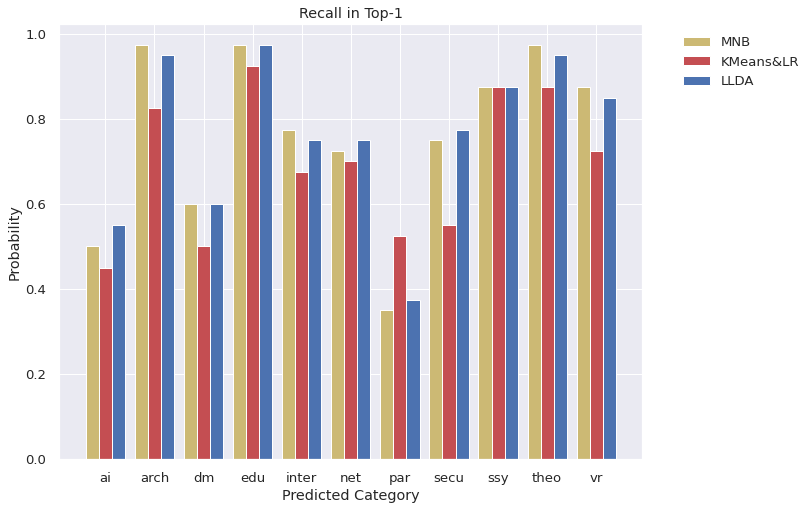

In [ ]:
plt.figure().set_size_inches(12,8)

x =list(range(len(NBdig)))
total_width, n = 0.8, 3
width = total_width / 3
 
plt.bar(x, NBdig, width=width, label='MNB',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, kdig, width=width, label='KMeans&LR', tick_label = class_labels, fc = 'r')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, ldig, width=width, label='LLDA', fc = 'b')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Predicted Category')
plt.ylabel('Probability')
plt.title('Recall in Top-1')
plt.subplots_adjust(right=0.8)

#plt.show()
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/recall1.jpg')

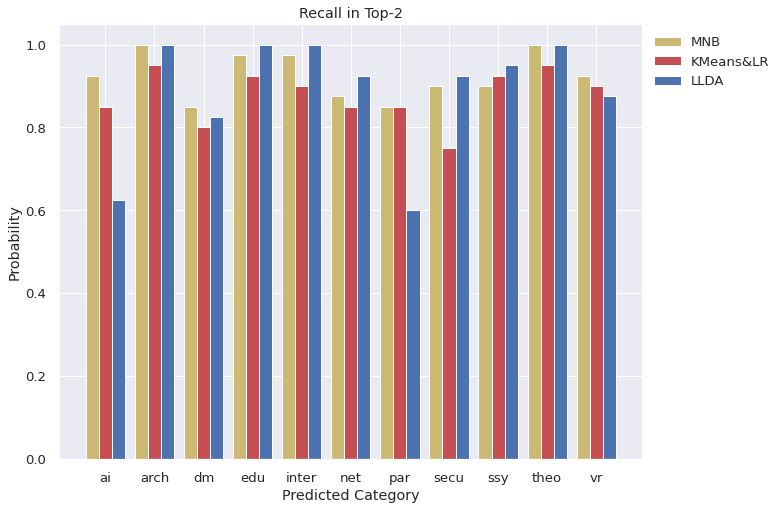

In [ ]:
plt.figure().set_size_inches(12,8)
x =list(range(len(NBdig2)))
total_width, n = 0.8, 3
width = total_width / 3
 
plt.bar(x, NBdig2, width=width, label='MNB',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, kdig2, width=width, label='KMeans&LR', tick_label = class_labels, fc = 'r')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, ldig2, width=width, label='LLDA', fc = 'b')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.xlabel('Predicted Category')
plt.ylabel('Probability')
plt.title('Recall in Top-2')
plt.subplots_adjust(right=0.8)

#plt.show()
plt.savefig('/content/drive/Shareddrives/My Dessertation/py/cs_txt/data3/recall2.jpg')